In [1]:
import os
import re
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import norm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# read in DAQ data .txt files, output as array with shape (#PMT (7), #events (~1e4-1e5), #samples (1024))
def read_data_from_file(file_path):
    header_lines = 8
    data_lines = 1024

    with open(file_path, 'r') as file:
        lines = file.readlines()
        total_lines = len(lines)
        total_data_sets = math.floor(total_lines/1032)
        file.close()

    with open(file_path, 'r') as file:

        # Skip the initial 8 header lines
        for _ in range(header_lines):
            next(file)

        # Initialize an empty list to store the data
        data = []

        # Read the data sets
        for _ in range(total_data_sets-1):
            if math.floor(_ % (total_data_sets/5)) == 0:
              print(f"{_} / {total_data_sets}")
            # Read the data lines
            data_set = [next(file).strip().split() for _ in range(data_lines)]
            data_set = [float(item) for sublist in data_set for item in sublist]
            data.append(data_set)

            # Skip the next 8 header lines
            for _ in range(header_lines):
                next(file)

    # Convert the list of data into a NumPy array
    data_arr = np.array(data)
    return data_arr

In [4]:
# read in data from June 16-19 measurement and output as array
file_path_0 = "/content/drive/MyDrive/Nikhef_project/Weekend_data/TR_0_0.txt"   # top scint
# distant scint plate "channel / file path 1 is not in this measurment, carefull with numbers"
file_path_2 = "/content/drive/MyDrive/Nikhef_project/Weekend_data/wave_2.txt"   # bottom scint
file_path_3 = "/content/drive/MyDrive/Nikhef_project/Weekend_data/wave_3.txt"   # PMTs 3-7
file_path_4 = "/content/drive/MyDrive/Nikhef_project/Weekend_data/wave_4.txt"
file_path_5 = "/content/drive/MyDrive/Nikhef_project/Weekend_data/wave_5.txt"
file_path_6 = "/content/drive/MyDrive/Nikhef_project/Weekend_data/wave_6.txt"
file_path_7 = "/content/drive/MyDrive/Nikhef_project/Weekend_data/wave_7.txt"

data_array_0 = read_data_from_file(file_path_0)
data_array_2 = read_data_from_file(file_path_2)
data_array_3 = read_data_from_file(file_path_3)
data_array_4 = read_data_from_file(file_path_4)
data_array_5 = read_data_from_file(file_path_5)
data_array_6 = read_data_from_file(file_path_6)
data_array_7 = read_data_from_file(file_path_7)

data_arr_arr = np.array([data_array_0, data_array_2, data_array_3, data_array_4, data_array_5, data_array_6, data_array_7])

0 / 5331
1067 / 5331
2133 / 5331
3199 / 5331
4265 / 5331
0 / 5331
1067 / 5331
2133 / 5331
3199 / 5331
4265 / 5331
0 / 5331
1067 / 5331
2133 / 5331
3199 / 5331
4265 / 5331
0 / 5331
1067 / 5331
2133 / 5331
3199 / 5331
4265 / 5331
0 / 5331
1067 / 5331
2133 / 5331
3199 / 5331
4265 / 5331
0 / 5331
1067 / 5331
2133 / 5331
3199 / 5331
4265 / 5331
0 / 5331
1067 / 5331
2133 / 5331
3199 / 5331
4265 / 5331


In [ ]:
print(data_arr_arr.shape)

(7, 5330, 1024)


In [ ]:
# calculate total number of events in a dataset by dividing the number of lines by the 1032 lines/event
def total_data_sets(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        total_lines = len(lines)
        total_data_sets = math.floor(total_lines/1032)
        return total_data_sets

# Coincidince finder old

In [ ]:
def coincidince_finder_old(data1, data2):
  peaks1 = []
  peaks2 = []
  true_index = []
  peaks1_num, peaks2_num = 0,0

  for i, x1 in enumerate(data1):
      x2 = data2[i]

      peak1, properties1 = find_peaks(-x1, prominence=25, width=10)
      peak2, properties2 = find_peaks(-x2, prominence=25, width=10)

      if peak1.size == 0:
          peaks1.append(100)
      else:
          peaks1.append(peak1[0])
          peaks1_num += 1

      if peak2.size == 0:
          peaks2.append(0)

      else:
          peaks2.append(peak2[0])
          peaks2_num += 1

  if peaks1_num !=0 and peaks2_num != 0:
    true_index = [i for i, x in enumerate(np.isclose(peaks1, peaks2, atol=35)) if x]
    # box: 90cm = 3 ns, diagonal: 150cm = 5ns, 5 sampels/ns --> 25 + margin = 35.
  return true_index, peaks1, peaks2

# Coincidence finder

In [5]:
# find the events in which both data1 and data2 arrays have a signal peak
def coincidence_finder(data1, data2):
    peaks1 = []
    peaks2 = []
    true_index = []

    for i, x1 in enumerate(data1):
        x2 = data2[i]

        peak1, properties1 = find_peaks(-x1, prominence=30, width=10)
        peak2, properties2 = find_peaks(-x2, prominence=30, width=10)

        if peak1.size == 0 or peak2.size == 0:
            continue
        else:
            for p1 in peak1:
                for p2 in peak2:
                    if abs(p1 - p2) <= 35:  # box: 90cm = 3 ns, diagonal: 150cm = 5ns, 5 sampels/ns --> 25 + margin = 35.
                                                # later changed to full 204.8 ns event instead
                        true_index.append((i))
                        peaks1.append(peak1)
                        peaks2.append(peak2)
                        break
    return true_index, peaks1, peaks2

Or skip that and use the true_index found:

In [ ]:
true_index, peaks1, peaks2 = coincidence_finder(data_array_0, data_array_2)
print(true_index)
print(len(true_index))

[8, 33, 34, 41, 51, 68, 68, 85, 118, 124, 161, 171, 178, 178, 179, 203, 210, 232, 261, 295, 336, 364, 365, 367, 380, 401, 411, 418, 423, 424, 439, 453, 461, 473, 477, 485, 490, 527, 529, 537, 568, 585, 588, 598, 601, 627, 647, 657, 658, 668, 670, 681, 681, 687, 694, 709, 731, 757, 775, 782, 783, 793, 800, 803, 820, 829, 852, 862, 863, 871, 939, 939, 955, 970, 997, 1008, 1009, 1039, 1044, 1057, 1072, 1104, 1112, 1113, 1129, 1131, 1134, 1164, 1189, 1198, 1199, 1211, 1213, 1214, 1255, 1263, 1275, 1279, 1298, 1312, 1330, 1335, 1336, 1360, 1367, 1368, 1375, 1386, 1392, 1415, 1434, 1442, 1442, 1472, 1484, 1495, 1506, 1520, 1526, 1534, 1546, 1551, 1583, 1589, 1591, 1613, 1615, 1617, 1628, 1660, 1664, 1677, 1681, 1683, 1685, 1712, 1738, 1749, 1755, 1756, 1768, 1768, 1782, 1785, 1792, 1799, 1806, 1824, 1829, 1842, 1858, 1866, 1871, 1872, 1874, 1881, 1885, 1891, 1934, 1936, 1936, 1963, 1965, 1988, 1995, 2005, 2006, 2010, 2026, 2032, 2032, 2039, 2039, 2039, 2052, 2070, 2071, 2073, 2076, 2078, 208

In [ ]:
# true_index = [8, 33, 41, 51, 68, 178, 179, 210, 411, 423, 453, 473, 477, 490, 511, 529, 537, 601, 647, 668, 709, 820, 862, 863, 871, 939, 955, 997, 1007, 1014, 1037, 1039, 1112, 1113, 1129, 1138, 1165, 1169, 1214, 1255, 1263, 1279, 1289, 1330, 1381, 1415, 1434, 1442, 1526, 1578, 1589, 1613, 1615, 1617, 1660, 1685, 1773, 1785, 1824, 1858, 1874, 1885, 1891, 1936, 1988, 1995, 2005, 2006, 2011, 2032, 2039, 2052, 2071, 2080, 2109, 2131, 2189, 2235, 2246, 2300, 2331, 2357, 2397, 2404, 2447, 2464, 2468, 2482, 2488, 2508, 2524, 2590, 2631, 2658, 2663, 2703, 2716, 2730, 2778, 2797, 2814, 2819, 2834, 2862, 2916, 2934, 2949, 2988, 2996, 2997, 3004, 3012, 3029, 3044, 3058, 3126, 3128, 3169, 3178, 3240, 3250, 3271, 3300, 3341, 3345, 3351, 3368, 3386, 3394, 3403, 3454, 3464, 3492, 3514, 3555, 3592, 3599, 3661, 3674, 3687, 3811, 3819, 3840, 3843, 3896, 3902, 3925, 3929, 3986, 4013, 4045, 4058, 4102, 4129, 4176, 4210, 4230, 4270, 4275, 4290, 4300, 4312, 4390, 4394, 4400, 4405, 4454, 4459, 4466, 4526, 4539, 4578, 4600, 4633, 4635, 4645, 4651, 4661, 4748, 4821, 4830, 4843, 4879, 4894, 4922, 4950, 4953, 4974, 4990, 4998, 5006, 5009, 5030, 5047, 5061, 5072, 5073, 5076, 5129, 5199, 5214, 5224, 5239, 5240, 5271, 5274, 5280, 5282, 5294, 5296, 5318]
true_index_new, peaks1, peaks2 = coincidence_finder(data_array_0, data_array_2)
true_index_old = [8, 33, 41, 68, 179, 411, 473, 477, 490, 529, 601, 647, 668, 820, 862, 863, 871, 955, 1039, 1112, 1129, 1263, 1279, 1330, 1442, 1589, 1615, 1617, 1660, 1685, 1785, 1874, 1885, 1891, 1995, 2006, 2032, 2039, 2052, 2071, 2080, 2109, 2131, 2189, 2235, 2246, 2508, 2524, 2590, 2631, 2663, 2778, 2797, 2814, 2834, 2916, 2949, 2988, 2997, 3029, 3044, 3058, 3128, 3169, 3178, 3250, 3386, 3403, 3454, 3464, 3492, 3514, 3599, 3819, 3896, 3902, 3929, 3986, 4045, 4058, 4102, 4129, 4176, 4300, 4312, 4394, 4400, 4459, 4466, 4633, 4635, 4661, 4830, 4843, 4879, 4894, 4953, 4974, 4990, 5006, 5030, 5072, 5076, 5129, 5199, 5214, 5239, 5271, 5274, 5280, 5282, 5294]
# print(sorted(list(set(true_index) - set(true_index_old)))) # difference between 20 vs 35 tollerence, new events with peaks,  # different prominance and width
print(sorted(list(set(true_index) - set(true_index_old))))
print(len(true_index_new))

[34, 51, 85, 118, 124, 161, 171, 178, 203, 210, 232, 261, 295, 336, 364, 365, 367, 380, 401, 418, 423, 424, 439, 453, 461, 485, 527, 537, 568, 585, 588, 598, 627, 657, 658, 670, 681, 687, 694, 709, 731, 757, 775, 782, 783, 793, 800, 803, 829, 852, 939, 970, 997, 1008, 1009, 1044, 1057, 1072, 1104, 1113, 1131, 1134, 1164, 1189, 1198, 1199, 1211, 1213, 1214, 1255, 1275, 1298, 1312, 1335, 1336, 1360, 1367, 1368, 1375, 1386, 1392, 1415, 1434, 1472, 1484, 1495, 1506, 1520, 1526, 1534, 1546, 1551, 1583, 1591, 1613, 1628, 1664, 1677, 1681, 1683, 1712, 1738, 1749, 1755, 1756, 1768, 1782, 1792, 1799, 1806, 1824, 1829, 1842, 1858, 1866, 1871, 1872, 1881, 1934, 1936, 1963, 1965, 1988, 2005, 2010, 2026, 2070, 2073, 2076, 2078, 2110, 2167, 2171, 2232, 2256, 2263, 2267, 2274, 2300, 2329, 2331, 2370, 2392, 2397, 2421, 2436, 2464, 2465, 2468, 2483, 2488, 2494, 2518, 2537, 2580, 2597, 2619, 2634, 2655, 2699, 2703, 2725, 2730, 2739, 2751, 2761, 2766, 2767, 2815, 2819, 2838, 2862, 2890, 2896, 2905, 2919,

In [8]:
# plot a particular signal
def plot_signal(data_array, channels, event):
  for channel in channels:
      plt.plot(np.linspace(0, 204.8, num=1024), data_array[channel][event], label = f'Channel {channel}')
      peak, properties = find_peaks(-data_array[channel][event], prominence=30, width=10)

      if len(peak) != 0:
            plt.plot(peak*0.2, data_array[channel][event][peak], "x", color = 'red')
            print(f'Peak for channel {channel} is at: {peak[0]/5} ns.')
      else:
          print(f'No peak found for channel {channel}.')
  plt.xlabel('Time [ns]')
  plt.ylabel('ADC')
  plt.title(f'Channel {channel}')
  plt.legend(fontsize="10")
  plt.show()

# plot_signal(data_arr_arr, [2,4,5,6], 0)
# plot_signal(data_june_30_arr, [5], true_index_june_30[33])

# Typical signal plot for presentation

In [ ]:
# plot for presentation
def plot_signal(data_array, channels, event):

  for channel in channels:
    print(channel)
    if channel == 1:
      plt.plot(np.linspace(0, 204.8, num=1024), data_array[channel-1][event] + 280, label = f'Top scint plate')
      peak, properties = find_peaks(-data_array[channel-1][event], prominence=40, width=20)
      if len(peak) != 0:
        plt.plot(peak*0.2, data_array[channel-1][event][peak] + 280, "x", color = 'red', markersize=10)
        print(f'Peak for channel {channel} is at: {peak[0]/5} ns.')

    if channel == 5:
      plt.plot(np.linspace(0, 204.8, num=1024), data_array[channel-1][event] - 50, label = f'PMT {channel}')
      peak, properties = find_peaks(-data_array[channel-1][event], prominence=30, width=20)
      if len(peak) != 0:
        plt.plot(peak*0.2, data_array[channel-1][event][peak] -50, "x", color = 'red')
        print(f'Peak for channel {channel} is at: {peak[0]/5} ns.')

    if channel == 4:
      plt.plot(np.linspace(0, 204.8, num=1024), data_array[channel-1][event] + 25, label = f'PMT {channel}')
      peak, properties = find_peaks(-data_array[channel-1][event], prominence=10, width=20)
      if len(peak) != 0:
        plt.plot(peak*0.2, data_array[channel-1][event][peak] +25, "x", color = 'red')
        print(f'Peak for channel {channel} is at: {peak[0]/5} ns.')
    if channel == 7:
      plt.plot(np.linspace(0, 204.8, num=1024), data_array[channel-1][event] - 25, label = f'PMT {channel}', color = 'cyan')
      peak, properties = find_peaks(-data_array[channel-1][event], prominence=15, width=10)
      if len(peak) != 0:
        plt.plot(peak*0.2, data_array[channel-1][event][peak] -25, "x", color = 'red')
        print(f'Peak for channel {channel} is at: {peak[0]/5} ns.')

    if channel == 6:
      plt.plot(np.linspace(0, 204.8, num=1024), data_array[channel-1][event] - 0, label = f'PMT {channel}')
      peak, properties = find_peaks(-data_array[channel-1][event], prominence=10, width=20)
      if len(peak) != 0:
        # plt.plot(peak*0.2, data_array[channel-1][event][peak] -0, "x", color = 'red')
        print(f'Peak for channel {channel} is at: {peak[0]/5} ns.')
    # else:
    #   print(f'No peak found for channel {channel}.')
  plt.xlabel('Time [ns]')
  plt.ylabel('ADC (offset)')
  plt.title('Typical multi PMT signal')
  plt.legend( fontsize="10")
  plt.show()

# plot_signal(data_arr_arr, [1,2,4,5,6,7], 0)

# Plot

Peak for channel 0 is at: 48.8 ns.
Peak for channel 1 is at: 52.2 ns.


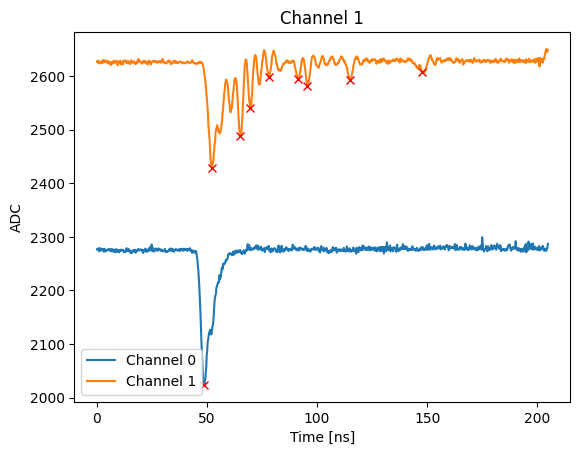

Peak for channel 0 is at: 51.0 ns.
Peak for channel 1 is at: 49.2 ns.


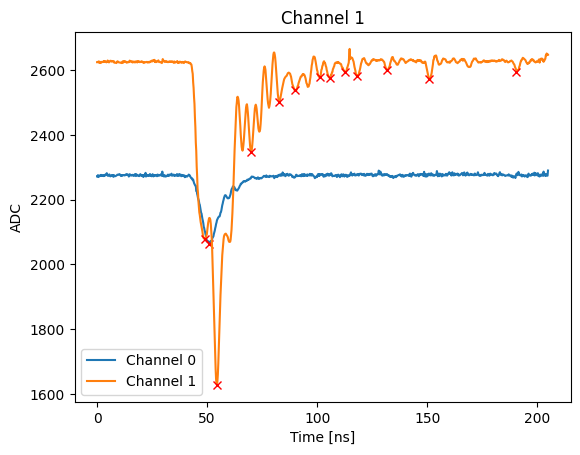

Peak for channel 0 is at: 55.4 ns.
Peak for channel 1 is at: 56.6 ns.


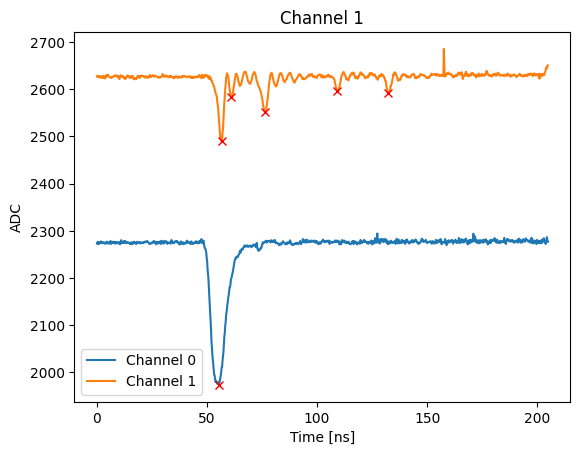

Peak for channel 0 is at: 50.4 ns.
Peak for channel 1 is at: 49.2 ns.


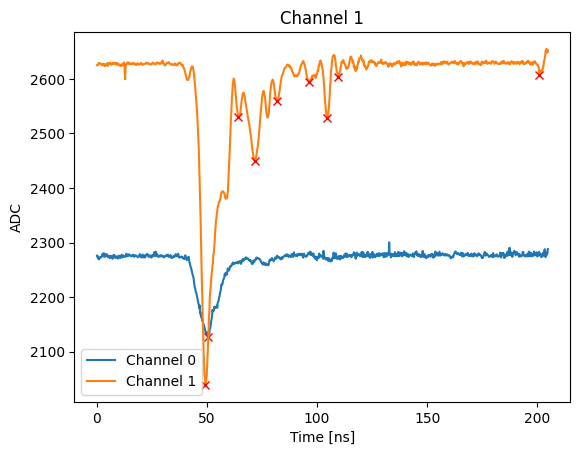

Peak for channel 0 is at: 54.6 ns.
Peak for channel 1 is at: 49.4 ns.


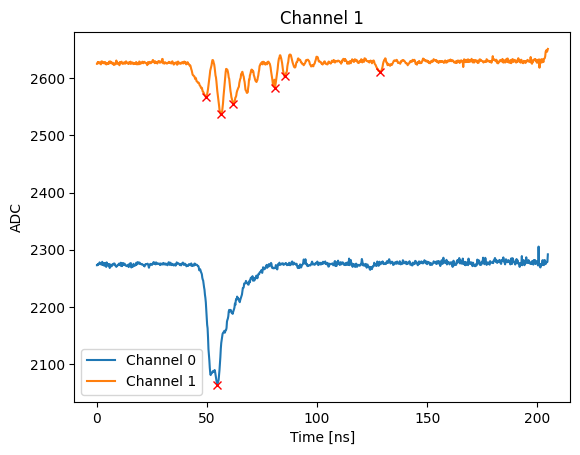

Peak for channel 0 is at: 51.6 ns.
Peak for channel 1 is at: 52.2 ns.


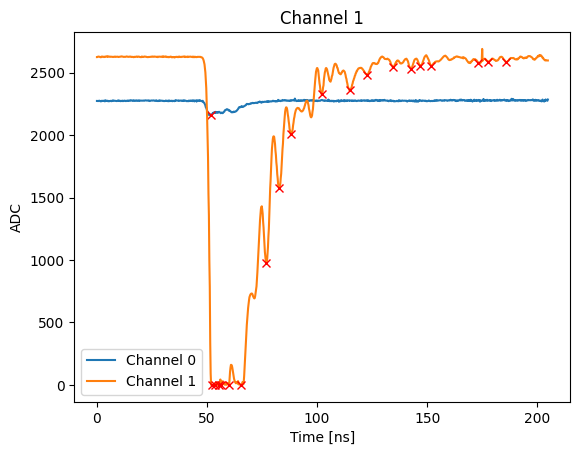

Peak for channel 0 is at: 51.6 ns.
Peak for channel 1 is at: 52.2 ns.


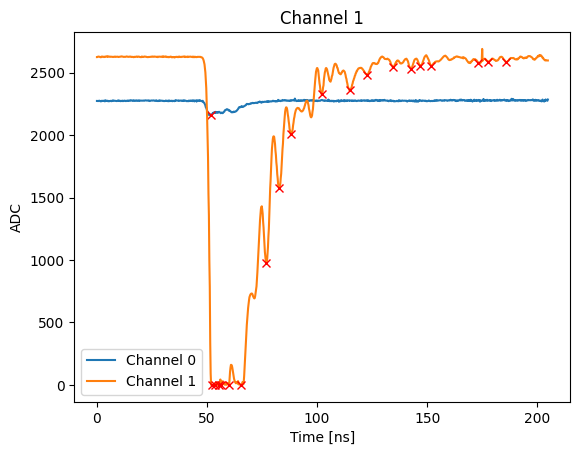

Peak for channel 0 is at: 49.2 ns.
Peak for channel 1 is at: 65.2 ns.


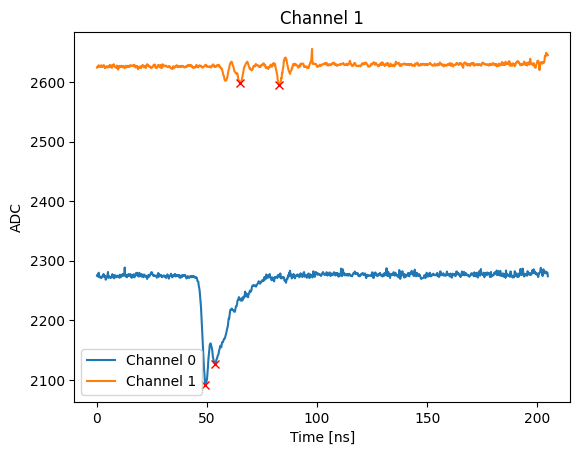

Peak for channel 0 is at: 53.6 ns.
Peak for channel 1 is at: 59.2 ns.


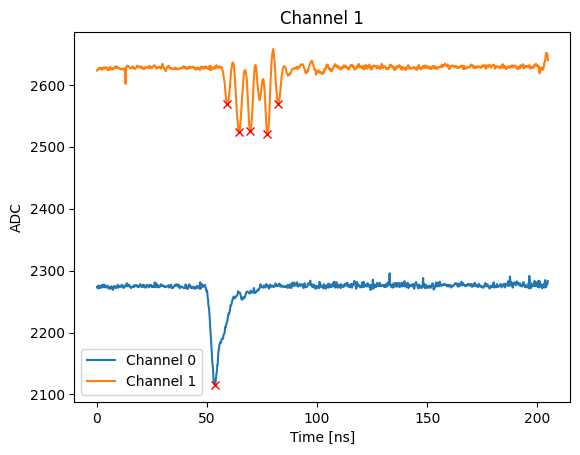

Peak for channel 0 is at: 54.0 ns.
Peak for channel 1 is at: 50.0 ns.


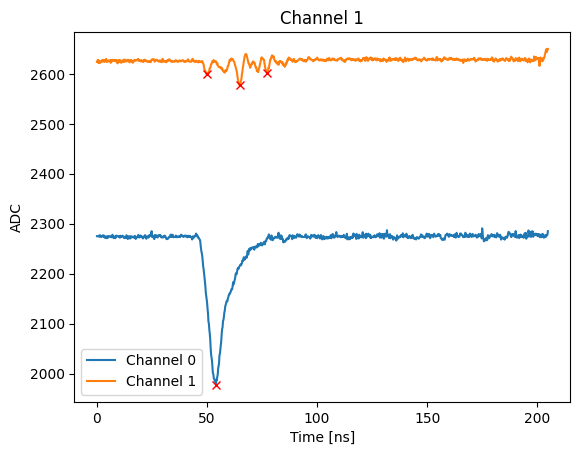

In [ ]:
for i in range(10):
  plot_signal(data_arr_arr, [0,1], true_index[i])

In [ ]:
channel, event = 1, 0
counts = -data_arr_arr[channel-1][event]

peaks, properties = find_peaks(counts, prominence=25, width=20)

plt.plot(np.linspace(0, 204.8, num=1024), -counts, label = f'Channel {channel}, event {event}')
plt.plot(peaks/5, -counts[peaks], "x", label = "Peak")
plt.vlines(x=peaks/5, ymin=-counts[peaks] + properties["prominences"],
           ymax = -counts[peaks], color = "C1")
plt.hlines(y=-properties["width_heights"], xmin=properties["left_ips"]/5,
           xmax=properties["right_ips"]/5, color = "C1")
plt.xlabel('Time [ns]')
plt.ylabel('ADC')
plt.legend()
plt.show()

# Test peaks

In [ ]:
# # test peaks for testing peak_area function
# counts = np.zeros(1024) + np.random.uniform(-2, 2, size=len(counts))
# peak = counts[300:311]
# peak += - 100000
# peak = counts[320+100:331+100]
# peak += - 100000

# test peaks for testing peak_area function
counts = np.zeros(1024) + np.random.uniform(-2, 2, size=len(counts))
peak = counts[300:340]
peak += - 6

# peak = counts[500:600]
# peak += - 6

peak = counts[800:850]
peak += - 1.5

# Peak area

In [6]:
def peak_area(data_arr_arr, channel, event):
  counts = data_arr_arr[channel][event] # ADC counts
  samples = np.arange(len(counts)) # number of samples
  baseline_section = np.concatenate((counts[:200], counts[-500:-30]))    # make this so it checks that there is not a pulse here, can be now we have multiple messing with baseline
  baseline = np.median(baseline_section) # median of the non trigger region, should be non pulse region
  baseline_std = np.std(baseline_section) # standard deviation of baseline region

  threshold = [(baseline - 3 * baseline_std)] * len(samples) # number of std is kind of arbitary still for now, high for now as we don't seperate peaks yet: decide, be consistent and explain justification
                                                                    # also need to decide if we want just single peak or not
  threshold =  threshold - baseline
  counts = counts - baseline # redefine baseline as zero

  peak, properties = find_peaks(-counts, prominence=30, width=10)
  if len(peak) != 0:
    pulse_start, pulse_end = find_largest_region(counts, threshold)

    area = abs(np.trapz(counts[pulse_start:pulse_end], samples[pulse_start:pulse_end]))
  else:
      area, pulse_start, pulse_end = 0,0,0

  return area, samples, counts, baseline, baseline_std, threshold, pulse_start, pulse_end

In [7]:
  # find the broadest region with a signal in the event
  def find_largest_region(counts, threshold):
    below_threshold_indices = np.where(np.array(counts) < threshold)[0]

    if len(below_threshold_indices) == 0:
        return None

    regions = []
    current_region = [below_threshold_indices[0], below_threshold_indices[0]]

    for i in below_threshold_indices[1:]:
        if i == current_region[1] + 1:
            current_region[1] = i
        else:
            regions.append(current_region)
            current_region = [i, i]

    regions.append(current_region)
    largest_region = max(regions, key=lambda region: region[1] - region[0])

    return largest_region[0], largest_region[1]

In [8]:
# make plot with pulse area marked
def plot_peak_area(data_arr_arr, channel, event):
  fig, ax = plt.subplots(figsize=(8,8))
  area, samples, counts, baseline, baseline_std, threshold, pulse_start, pulse_end = peak_area(data_arr_arr, channel, event)
  ax.plot(samples, counts, label=f'Event {event}')
  plt.axhline(0, color='orange', label='Baseline')
  ax.plot(samples, threshold, color='g', label='Threshold')

  peak, properties = find_peaks(-data_arr_arr[channel][event], prominence=25, width=20)
  if len(peak) != 0:
    plt.fill_between(np.arange(pulse_start, pulse_end), counts[pulse_start:pulse_end], color='r', alpha=0.5, label='Peak')
    plt.title(f'Channel {channel}, event {event}, pulse area = {area/5/13.2:.0f} mV * ns') # 1/5 ns /sample, 13.2 ADC / mV
  else:
    plt.title(f'Channel {channel}, event {event}, No pulse')

  plt.xlabel('Sample number (0.2 ns / sample)')
  plt.ylabel('ADC - baseline')
  ax.set_xlim(0, len(samples))
  # ax.set_ylim(-20, 10)
  ax.legend()
  plt.show()
  print(f"Pulse starts at line {pulse_start} ({pulse_start/5} [ns]) and ends at line {pulse_end} ({pulse_end/5} [ns])")
  print(f"Baseline = {baseline:.0f}, baseline_std = {baseline_std:.2f}, threshold = {threshold[0]:.0f}.")
  print(f"area = {area/5/13.2:.0f}")
  print("")

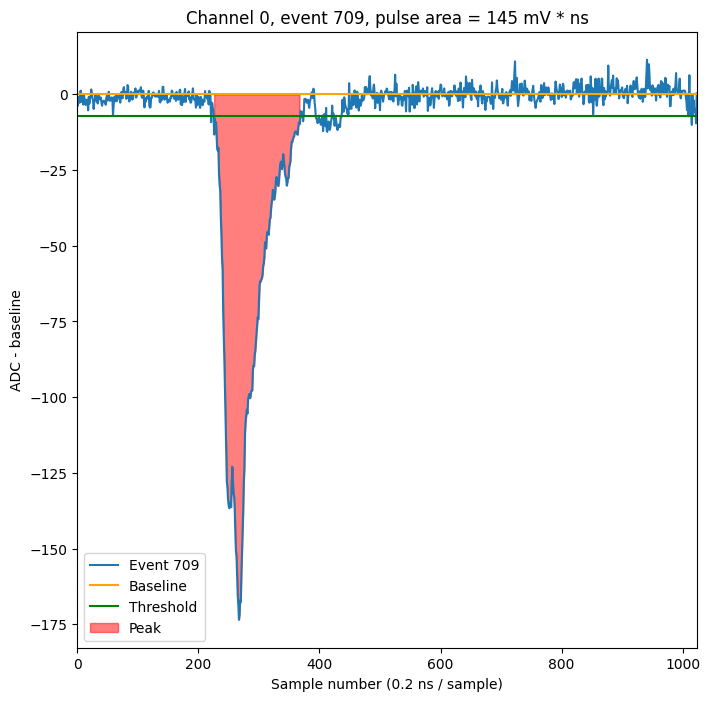

Pulse starts at line 226 (45.2 [ns]) and ends at line 368 (73.6 [ns])
Baseline = 2274, baseline_std = 2.37, threshold = -7.
area = 145



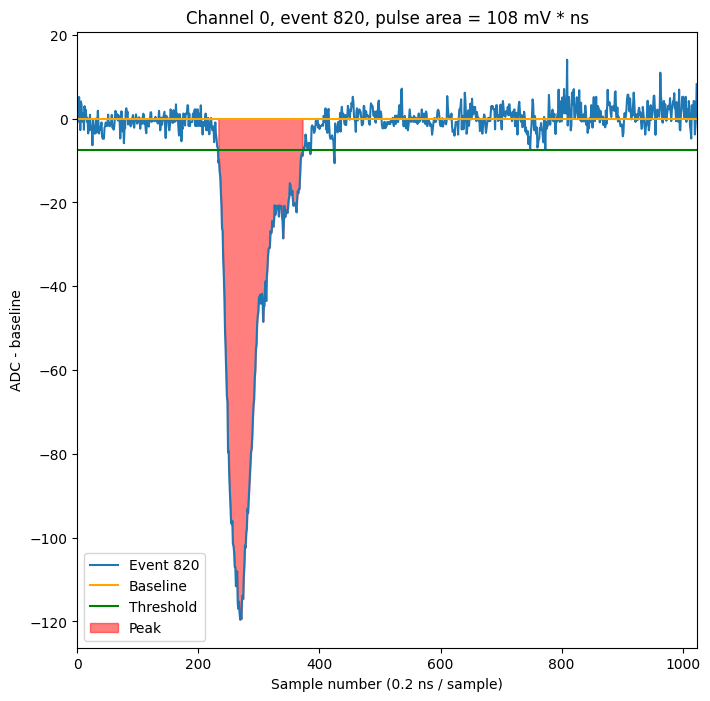

Pulse starts at line 233 (46.6 [ns]) and ends at line 373 (74.6 [ns])
Baseline = 2273, baseline_std = 2.48, threshold = -7.
area = 108



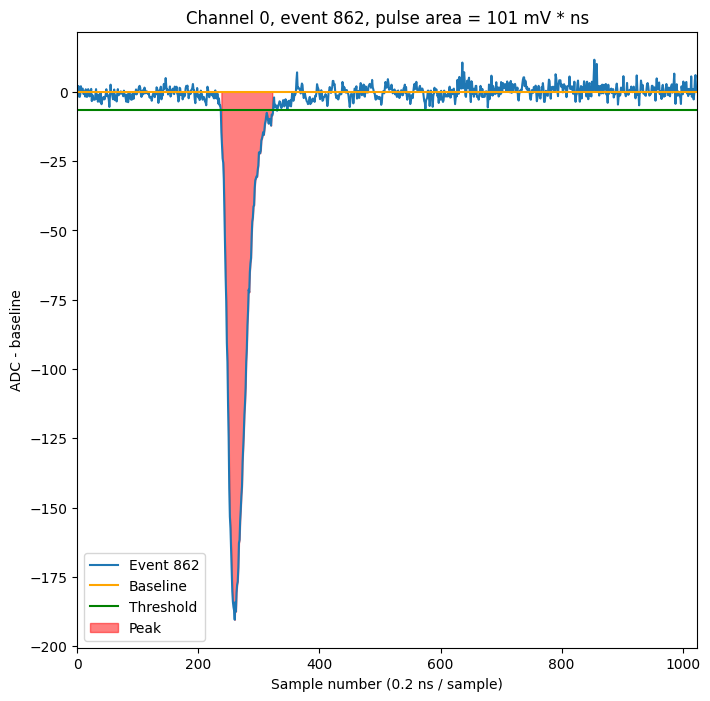

Pulse starts at line 238 (47.6 [ns]) and ends at line 323 (64.6 [ns])
Baseline = 2273, baseline_std = 2.21, threshold = -7.
area = 101



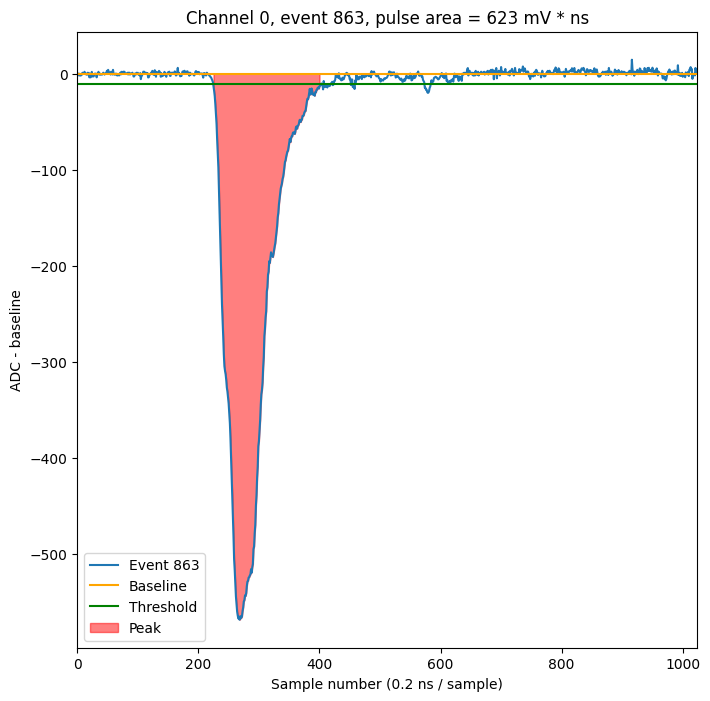

Pulse starts at line 225 (45.0 [ns]) and ends at line 401 (80.2 [ns])
Baseline = 2272, baseline_std = 3.66, threshold = -11.
area = 623



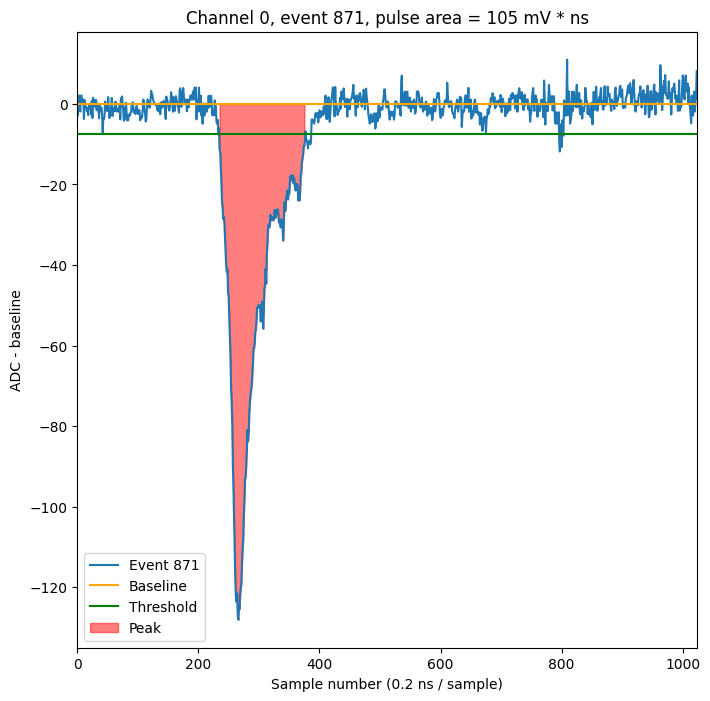

Pulse starts at line 235 (47.0 [ns]) and ends at line 376 (75.2 [ns])
Baseline = 2273, baseline_std = 2.49, threshold = -7.
area = 105



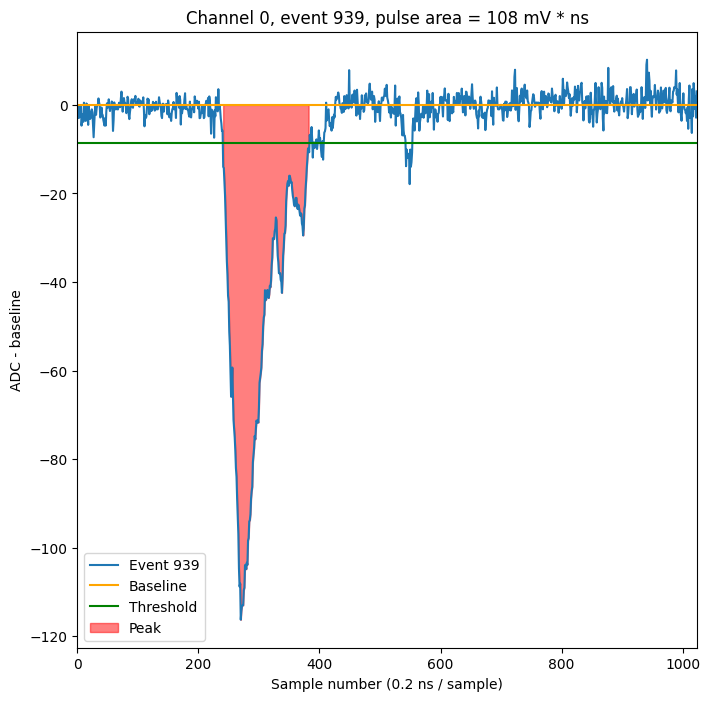

Pulse starts at line 241 (48.2 [ns]) and ends at line 383 (76.6 [ns])
Baseline = 2273, baseline_std = 2.84, threshold = -9.
area = 108



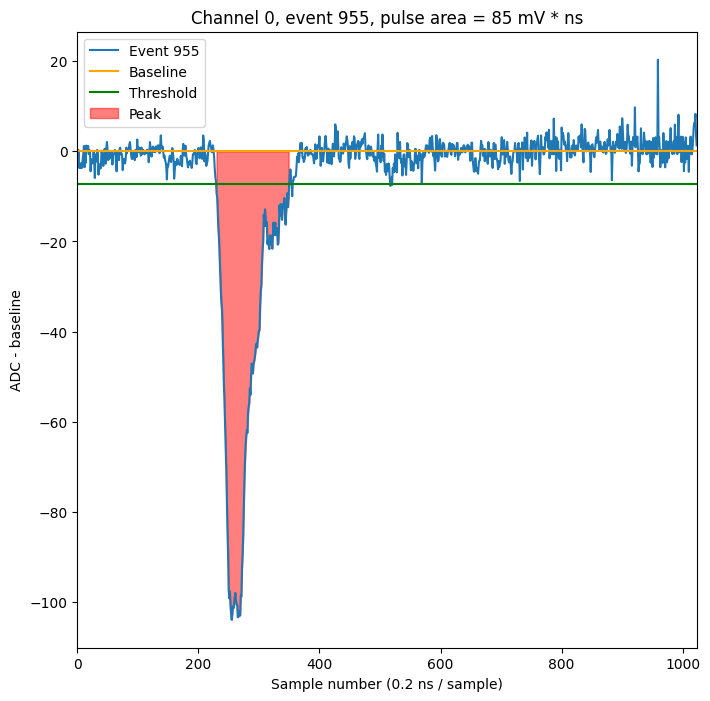

Pulse starts at line 230 (46.0 [ns]) and ends at line 350 (70.0 [ns])
Baseline = 2273, baseline_std = 2.38, threshold = -7.
area = 85



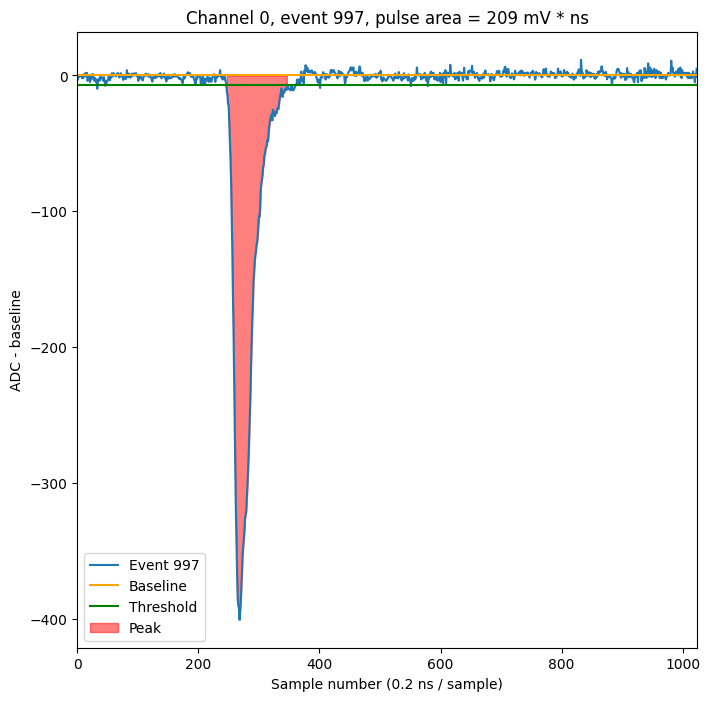

Pulse starts at line 247 (49.4 [ns]) and ends at line 347 (69.4 [ns])
Baseline = 2273, baseline_std = 2.46, threshold = -7.
area = 209



In [10]:
true_index = [8, 33, 41, 51, 68, 178, 179, 210, 411, 423, 453, 473, 477, 490, 511, 529, 537, 601, 647, 668, 709, 820, 862, 863, 871, 939, 955, 997, 1007, 1014, 1037, 1039, 1112, 1113, 1129, 1138, 1165, 1169, 1214, 1255, 1263, 1279, 1289, 1330, 1381, 1415, 1434, 1442, 1526, 1578, 1589, 1613, 1615, 1617, 1660, 1685, 1773, 1785, 1824, 1858, 1874, 1885, 1891, 1936, 1988, 1995, 2005, 2006, 2011, 2032, 2039, 2052, 2071, 2080, 2109, 2131, 2189, 2235, 2246, 2300, 2331, 2357, 2397, 2404, 2447, 2464, 2468, 2482, 2488, 2508, 2524, 2590, 2631, 2658, 2663, 2703, 2716, 2730, 2778, 2797, 2814, 2819, 2834, 2862, 2916, 2934, 2949, 2988, 2996, 2997, 3004, 3012, 3029, 3044, 3058, 3126, 3128, 3169, 3178, 3240, 3250, 3271, 3300, 3341, 3345, 3351, 3368, 3386, 3394, 3403, 3454, 3464, 3492, 3514, 3555, 3592, 3599, 3661, 3674, 3687, 3811, 3819, 3840, 3843, 3896, 3902, 3925, 3929, 3986, 4013, 4045, 4058, 4102, 4129, 4176, 4210, 4230, 4270, 4275, 4290, 4300, 4312, 4390, 4394, 4400, 4405, 4454, 4459, 4466, 4526, 4539, 4578, 4600, 4633, 4635, 4645, 4651, 4661, 4748, 4821, 4830, 4843, 4879, 4894, 4922, 4950, 4953, 4974, 4990, 4998, 5006, 5009, 5030, 5047, 5061, 5072, 5073, 5076, 5129, 5199, 5214, 5224, 5239, 5240, 5271, 5274, 5280, 5282, 5294, 5296, 5318]
for i in range(20,28):
  plot_peak_area(data_arr_arr, 0, true_index[i])

In [ ]:
channel, event = 5, 1007
area, samples, counts, baseline, baseline_std, threshold, pulse_start, pulse_end = peak_area(data_june_30_arr, channel, event)

# make plot with pulse area marked
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(samples, counts, label=f'Event {event}')

plt.axhline(0, color='r', label='Baseline')
ax.plot(samples, threshold, color='g', label='Threshold')
plt.fill_between(range(pulse_start, pulse_end), counts[pulse_start:pulse_end], color='r', alpha=0.5)

plt.xlabel('Sample number (0.2 ns/sample)')
plt.ylabel('ADC - baseline')
plt.title(f'Pulse area = {area/5:.0f} mV * ns')
ax.set_xlim(0, len(samples))

ax.legend()
plt.show()

print(f"Pulse starts at line {pulse_start} and ends at line {pulse_end}") # divide by 5 for ns
print(f"Baseline = {baseline:.0f}, baseline_std = {baseline_std:.2f}, threshold = {threshold[0]:.0f}.")
print(f"Pulse area = {area:.0f/5}")

In [ ]:
def plot_hist_area(data_arr_arr, channel, events, title):
  area_array = []
  for event in events:
    if peak_area(data_arr_arr, channel, event)[0] != 0:
      area_array.append(peak_area(data_arr_arr, channel, event)[0])
    else:
      continue

  plt.hist(area_array, bins=50, edgecolor='black') # range=(10, 20000)
  plt.title(f'Channel {channel}, {title}, n = {len(area_array)}')
  plt.ylabel('Number of events')
  plt.xlabel('Pulse area')
  plt.show()

# June 16-19 weekend data histogram plots (low number)

In [ ]:
plot_hist_area(data_arr_arr, 1, true_index, "coincidence events")

In [ ]:
plot_hist_area(data_arr_arr, 2, true_index, "coincidence events")

In [ ]:
plot_hist_area(data_arr_arr, 1, np.arange(len(data_array_1)), "All top scint trigger events with peak")

In [ ]:
plot_hist_area(data_arr_arr, 2, np.arange(len(data_array_1)), f"All top scint trigger events with peak on channel {channel}")

In [ ]:
plot_hist_area(data_arr_arr, 4, true_index, "coincidence events")

In [ ]:
plot_hist_area(data_arr_arr, 5, true_index, "coincidence events")

In [ ]:
plot_hist_area(data_arr_arr, 7, true_index, "coincidence events")

# June 23-26 data

In [ ]:
# Data June 23-26 (bottom scint plate broken)
file_path_0 = "/content/drive/MyDrive/Nikhef_project/DATA/June 23 Weekend 2/wave_0.txt" # distant scint plate
file_path_1 = "/content/drive/MyDrive/Nikhef_project/DATA/June 23 Weekend 2/TR_0_0.txt" # top scint plate
file_path_2 = "/content/drive/MyDrive/Nikhef_project/DATA/June 23 Weekend 2/wave_2.txt" # bottom scint plate
# file_path_3 = "/content/drive/MyDrive/Nikhef_project/Weekend_data/wave_3.txt" # google drive out of storage..
file_path_4 = "/content/drive/MyDrive/Nikhef_project/DATA/June 23 Weekend 2/wave_4.txt"
file_path_5 = "/content/drive/MyDrive/Nikhef_project/DATA/June 23 Weekend 2/wave_5.txt"
file_path_6 = "/content/drive/MyDrive/Nikhef_project/DATA/June 23 Weekend 2/wave_6.txt"
file_path_7 = "/content/drive/MyDrive/Nikhef_project/DATA/June 23 Weekend 2/wave_7.txt"

data_array_2_0 = read_data_from_file(file_path_0) # distant scint plate
data_array_2_1 = read_data_from_file(file_path_1) # top scint plate
data_array_2_2 = read_data_from_file(file_path_2) # bottom scint plate
# data_array_2_3 = read_data_from_file(file_path_3)
data_array_2_4 = read_data_from_file(file_path_4)
data_array_2_5 = read_data_from_file(file_path_5)
data_array_2_6 = read_data_from_file(file_path_6)
data_array_2_7 = read_data_from_file(file_path_7)

data_arr_arr_2 = np.array([data_array_2_0, data_array_2_1, data_array_2_2, data_array_2_4, data_array_2_4, data_array_2_5, data_array_2_6, data_array_2_7])
# no data for channel 3 yet!! ^^

In [ ]:
coincidence_2, peaks1, peaks2 = coincidince_finder(data_array_2_1, data_array_2_2)
print(coincidence_2)
print(peaks1)
print(peaks2)
print(sum(peaks2))

index = []
for i in range(len(peaks2)):
  if peaks2[i] != 0:
    index.append(i)
print(index)
# very few events on bottom scint plate (broken).

In [ ]:
peaks = []
for i in range (43932):
  peak, properties = find_peaks(-data_arr_arr_2[2][i], prominence=40, width=20)
  peaks.append(peak)
print(peaks)

In [ ]:
# for event in range(10):
channels, event = [1,2], 15928
# channels = [1,2]
plot_signal(data_arr_arr_2, channels, event)

In [ ]:
channel, event = 2, 8

plot_peak_area(data_arr_arr_2, channel, event)

# Calibration

In [ ]:
# Calibration data
file_path_3 = "/content/drive/MyDrive/Nikhef_project/DATA/WCD PMT calibration data/wave_3.txt" # PMT 3
file_path_4 = "/content/drive/MyDrive/Nikhef_project/DATA/WCD PMT calibration data/wave_4.txt" # PMT 4
file_path_5 = "/content/drive/MyDrive/Nikhef_project/DATA/WCD PMT calibration data/wave_5.txt" # PMT 5
file_path_6 = "/content/drive/MyDrive/Nikhef_project/DATA/WCD PMT calibration data/wave_6.txt" # PMT 6
file_path_7 = "/content/drive/MyDrive/Nikhef_project/DATA/WCD PMT calibration data/wave_7.txt" # PMT 7

data_cal_1_3 = read_data_from_file(file_path_3)
data_cal_1_4 = read_data_from_file(file_path_4)
data_cal_1_5 = read_data_from_file(file_path_5)
data_cal_1_6 = read_data_from_file(file_path_6)
data_cal_1_7 = read_data_from_file(file_path_7)

data_arr_cal_1 = np.array([data_cal_1_3, data_cal_1_4, data_cal_1_5, data_cal_1_6, data_cal_1_7])

In [ ]:
peaks = []
num = 0
for event in range(0, 67676):
  if event % 10000 == 0:
    print(f'{event}/67677')
# for event in range(data_array_1.shape[0]): # trigger data
  # counts = -data_arr_cal_1[PMT-3][event]
  counts = data_cal_1_3[event]
  # counts = data_array_1[event] # trigger data
  peak, properties = find_peaks(-counts, prominence=40, width=20)
  if len(peak) != 0:
    peaks.append(peak)

  if event == 0:
    baseline_section = np.concatenate((counts[:200], counts[-500:]))
    baseline = np.mean(baseline_section)
    baseline_std = np.std(baseline_section)
    # counts = counts - baseline

    threshold = 0.95*baseline - 0 * baseline_std # number of std is kind of arbitary still for now, high for now as we don't seperate peaks yet
                                                                      # also need to decide if we want just single peak or not, now it accepts multiple

    print(threshold)
  if min(counts) < threshold:
    num +=1
    # print(event)

print("num of peaks", len(peaks))
print("num=", num)

counts = data_cal_1_7[11634]
i = 0
plt.plot(np.linspace(0, 204.8, num=1024), counts) #, label = f'Channel {channel}, event {event}')
# plt.plot(peaks[i]/5, counts[peaks[i]], "x", label = "Peak")
# plt.vlines(x=peaks[i]/5, ymin=-counts[peaks[i]] + properties["prominences"],
#           ymax = -counts[peaks[i]], color = "C1")
# plt.hlines(y=-properties["width_heights"], xmin=properties["left_ips"]/5,
#           xmax=properties["right_ips"]/5, color = "C1")
plt.xlabel('Time [ns]')
plt.ylabel('ADC')
plt.legend()
plt.show()

In [10]:
def calibration(data_arr):

  peaks = []
  num = 0

  for event in range(0, len(data_arr)):

    if event % 10000 == 0:
      print(f'{event}/{len(data_arr)}')

    counts = data_arr[event]

    peak, properties = find_peaks(-counts, prominence=40, width=20)
    if len(peak) != 0:
      peaks.append(peak)

    if event == 0:
      baseline_section = np.concatenate((counts[:200], counts[-500:]))
      baseline = np.mean(baseline_section)
      baseline_std = np.std(baseline_section)
      # counts = counts - baseline

      threshold = 0.95*baseline - 0 * baseline_std # number of std is kind of arbitary still for now, high for now as we don't seperate peaks yet
                                                                        # also need to decide if we want just single peak or not, now it accepts multiple

    if min(counts) < threshold:
      num +=1

  print("num of peaks", len(peaks))
  print("num=", num)

  return num, len(peaks)

In [ ]:
num, num_peaks = calibration(data_arr_cal_1)
print(num, num_peaks)

In [ ]:
counts = data_cal_1_7[11634]
i = 0
plt.plot(np.linspace(0, 204.8, num=1024), counts) #, label = f'Channel {channel}, event {event}')
# plt.plot(peaks[i]/5, counts[peaks[i]], "x", label = "Peak")
# plt.vlines(x=peaks[i]/5, ymin=-counts[peaks[i]] + properties["prominences"],
#           ymax = -counts[peaks[i]], color = "C1")
# plt.hlines(y=-properties["width_heights"], xmin=properties["left_ips"]/5,
#           xmax=properties["right_ips"]/5, color = "C1")
plt.xlabel('Time [ns]')
plt.ylabel('ADC')
plt.legend()
plt.show()

# Old event rate from timestamp tests

In [ ]:
def total_data_sets(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        total_lines = len(lines)
        total_data_sets = math.floor(total_lines/1032)
        return total_data_sets

In [ ]:
def time_frame(file_path):
  with open(file_path, 'r') as file:
      lines = file.readlines()
      time_line_strings = lines[5::1032]
      timestamps = []

      for i in range(len(time_line_strings)):
        time_line_string = time_line_strings[i]
        timestamp = int(time_line_string.split(":")[-1])
        timestamps.append(timestamp)
      return timestamps
      # total_lines = len(lines)
      # total_data_sets = math.floor(total_lines/1032)
          # return timeframe
# timestamps = time_frame("/content/drive/MyDrive/Nikhef_project/DATA/June 29 calibration/PMT4/TR_0_0.txt")

# for i in range(15):
#   print(10**9/(timestamps[i+1]-timestamps[i])/8.5)
#   # freq: 246, 72, 82, 73, 77 Hz


# timestamps = time_frame("/content/drive/MyDrive/Nikhef_project/DATA/June 29 calibration/wave_2.txt")
# print(timestamps)
# for i in range(len(timestamps)-1):
#   print(10**9/(timestamps[i+1]-timestamps[i])/8.5)
#   # freq: ~1 Hz

# Bottom plate calibration

In [ ]:
folder_path = '/content/drive/MyDrive/Nikhef_project/DATA/June 30 calibration/Bottom scint plate'

HV_list = []
timeframe_list = []
total_data_sets_list = []
counts_per_min_list = []
y_err = []

for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)

        matches = re.findall(r'(\d+)\s+(\d+\.\d+)', filename)
        HV = int(matches[0][0])
        timeframe = float(matches[0][1])

        HV_list.append(HV) #V
        timeframe_list.append(timeframe) #seconds

        with open(file_path, 'r') as file:

          lines = file.readlines()
          total_lines = len(lines)
          total_data_sets = math.floor(total_lines/1032)
          total_data_sets_list.append(total_data_sets)

        counts_per_sec = total_data_sets / timeframe
        counts_per_min_list.append(counts_per_sec*60)
        y_err.append(2*math.sqrt(counts_per_sec*60))

x_err = [5] * 5 + [10] * 9


print(sorted(HV_list))
plt.xlabel("PMT voltage [V]")
plt.ylabel("Counts / minute")
plt.title("Bottom scintillator plate PMT calibration")
plt.errorbar(HV_list, counts_per_min_list, xerr=x_err, yerr=y_err, fmt='o', ms=3);

# errorbars, above 2V  (2000V) only up to 2.00 accuarcy
# do both adc to voltage, and try dark count --> photons, compare with kelin

# went back and forth below and above jump to check, waited 1-2 min in between to let voltage settle

[1400, 1519, 1585, 1608, 1644, 1675, 1701, 1717, 1726, 1739, 1740]


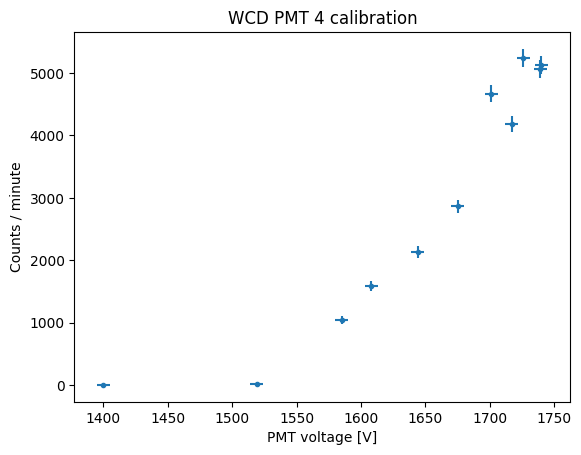

In [ ]:
folder_path = '/content/drive/MyDrive/Nikhef_project/DATA/June 29 calibration/PMT4'

HV_list = []
timeframe_list = []
total_data_sets_list = []
counts_per_min_list = []
y_err = []

for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)

        matches = re.findall(r'(\d+)\s+(\d+\.\d+)', filename)
        HV = int(matches[0][0])
        timeframe = float(matches[0][1])

        HV_list.append(HV) #V
        timeframe_list.append(timeframe) #seconds

        with open(file_path, 'r') as file:

          lines = file.readlines()
          total_lines = len(lines)
          total_data_sets = math.floor(total_lines/1032)
          total_data_sets_list.append(total_data_sets)

        counts_per_sec = total_data_sets / timeframe
        counts_per_min_list.append(counts_per_sec*60)
        y_err.append(2*math.sqrt(counts_per_sec*60))

x_err = [5] * len(HV_list)

print(sorted(HV_list))
plt.xlabel("PMT voltage [V]")
plt.ylabel("Counts / minute")
plt.title("WCD PMT 4 calibration")
plt.errorbar(HV_list, counts_per_min_list, xerr=x_err, yerr=y_err, fmt='o', ms=3);

# June 30 Load data

In [ ]:
# June 30th Window measurment
# redo this part, slow, takes lots of RAM, make it so all plots are made for each file step by step, replace data array when moving to next channel?
file_path_0 = "/content/drive/MyDrive/Nikhef_project/DATA/June 30 window measurment/TR_0_0.txt" # top scint
file_path_1 = "/content/drive/MyDrive/Nikhef_project/DATA/June 30 window measurment/wave_1.txt" # distant scint
file_path_2 = "/content/drive/MyDrive/Nikhef_project/DATA/June 30 window measurment/wave_2.txt" # bottom scint
file_path_3 = "/content/drive/MyDrive/Nikhef_project/DATA/June 30 window measurment/wave_3.txt" # PMT 3
file_path_4 = "/content/drive/MyDrive/Nikhef_project/DATA/June 30 window measurment/wave_4.txt" # PMT 4
file_path_5 = "/content/drive/MyDrive/Nikhef_project/DATA/June 30 window measurment/wave_5.txt" # PMT 5
file_path_6 = "/content/drive/MyDrive/Nikhef_project/DATA/June 30 window measurment/wave_6.txt" # PMT 6
file_path_7 = "/content/drive/MyDrive/Nikhef_project/DATA/June 30 window measurment/wave_7.txt" # PMT 7

data_june_30_0 = read_data_from_file(file_path_0)
data_june_30_1 = read_data_from_file(file_path_1)
data_june_30_2 = read_data_from_file(file_path_2)
data_june_30_3 = read_data_from_file(file_path_3)
data_june_30_4 = read_data_from_file(file_path_4)
data_june_30_5 = read_data_from_file(file_path_5)
data_june_30_6 = read_data_from_file(file_path_6)
data_june_30_7 = read_data_from_file(file_path_7)

data_june_30_arr = np.array([data_june_30_0, data_june_30_1, data_june_30_2, data_june_30_3, data_june_30_4, data_june_30_5, data_june_30_6, data_june_30_7])

# Plot

In [ ]:
def plot_hist_counts(data_arr, channel, title):
  H, bins = np.histogram(data_arr[channel], bins=100)#, range=(2500,2600))
  # H, bins = np.histogram(data_arr, bins=100)#, range=(2500,2600))

  plt.bar(bins[:-1], H, width=(np.ediff1d(bins)))
  plt.yscale('log')
  plt.ylabel('Number of samples')
  plt.xlabel('ADC counts')
  plt.title(f'{title}, Events = {len(data_arr[channel])}')
  plt.show()

# June 30 ADC Historgram plots

In [ ]:
plot_hist_counts(data_june_30_0, 0, "Top scint plate - ADC count distribution")

In [ ]:
plot_hist_counts(data_june_30_1, 1, "Distant scint plate 165 cm - ADC count distribution")

In [ ]:
plot_hist_counts(data_june_30_2, 2, "Bottom scint plate - ADC count distribution")

In [ ]:
for i in range(2,7):
  plot_hist_counts(data_june_30_arr[i], i+1, f"PMT {i+1} - ADC count distribution")
  print("")
# PMT 3 broken, just hovering around noise, wierd shape tho?

# June 29th LOAD DATA

In [ ]:
# June 29th Wall - angle measurment

file_path_0 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/TR_0_0.txt" # top scint
file_path_1 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/wave_1.txt" # distant scint
file_path_2 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/wave_2.txt" # bottom scint
file_path_3 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/wave_3.txt" # PMT 3
file_path_4 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/wave_4.txt" # PMT 4
file_path_5 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/wave_5.txt" # PMT 5
file_path_6 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/wave_6.txt" # PMT 6
file_path_7 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/wave_7.txt" # PMT 7

data_june_29_0 = read_data_from_file(file_path_0);
data_june_29_1 = read_data_from_file(file_path_1);
data_june_29_2 = read_data_from_file(file_path_2);
data_june_29_3 = read_data_from_file(file_path_3);
data_june_29_4 = read_data_from_file(file_path_4);
data_june_29_5 = read_data_from_file(file_path_5);
data_june_29_6 = read_data_from_file(file_path_6);
data_june_29_7 = read_data_from_file(file_path_7);

# data_june_29_arr = np.array([data_june_29_0, data_june_29_2, data_june_29_4, data_june_29_4, data_june_29_5, data_june_29_4, data_june_29_4])

data_june_29_arr = np.array([data_june_29_0, data_june_29_1, data_june_29_2, data_june_29_3, data_june_29_4, data_june_29_5, data_june_29_6, data_june_29_7])

0 / 34657
6932 / 34657
13863 / 34657
20795 / 34657
27726 / 34657
0 / 34657
6932 / 34657
13863 / 34657
20795 / 34657
27726 / 34657
0 / 34657
6932 / 34657
13863 / 34657
20795 / 34657
27726 / 34657
0 / 34657
6932 / 34657
13863 / 34657
20795 / 34657
27726 / 34657
0 / 34657
6932 / 34657
13863 / 34657
20795 / 34657
27726 / 34657
0 / 34657
6932 / 34657
13863 / 34657
20795 / 34657
27726 / 34657
0 / 34657
6932 / 34657
13863 / 34657
20795 / 34657
27726 / 34657
0 / 34657
6932 / 34657
13863 / 34657
20795 / 34657
27726 / 34657


# June 29 ADC Histogram plots

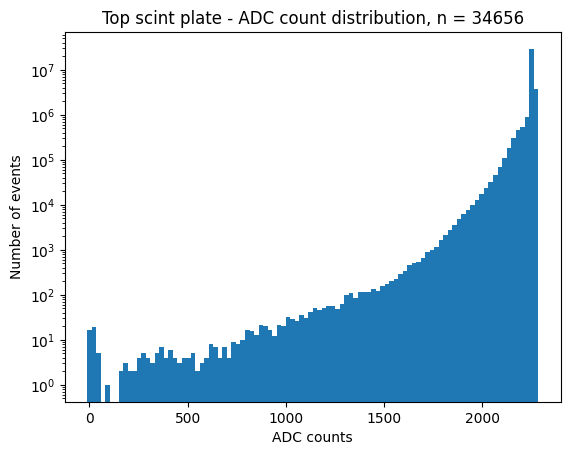

In [ ]:
plot_hist_counts(data_june_29_0, 0, "Top scint plate - ADC count distribution")

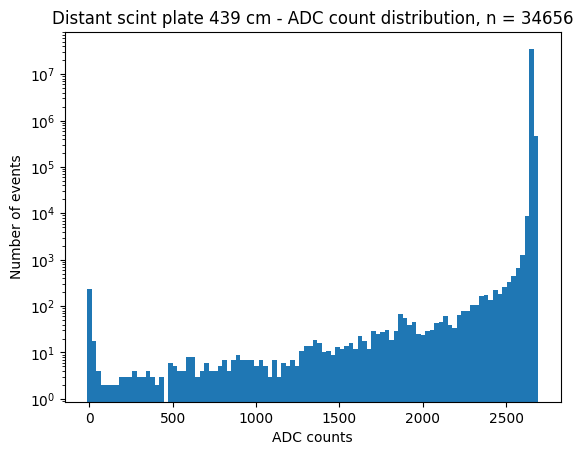

In [ ]:
plot_hist_counts(data_june_29_1, 1, "Distant scint plate 439 cm - ADC count distribution")

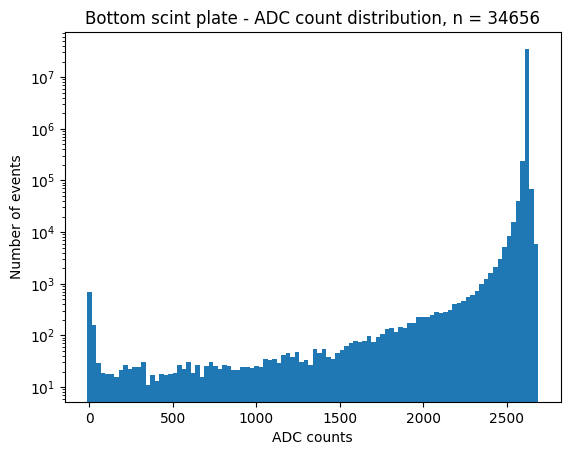

In [ ]:
plot_hist_counts(data_june_29_2, 2, "Bottom scint plate - ADC count distribution")

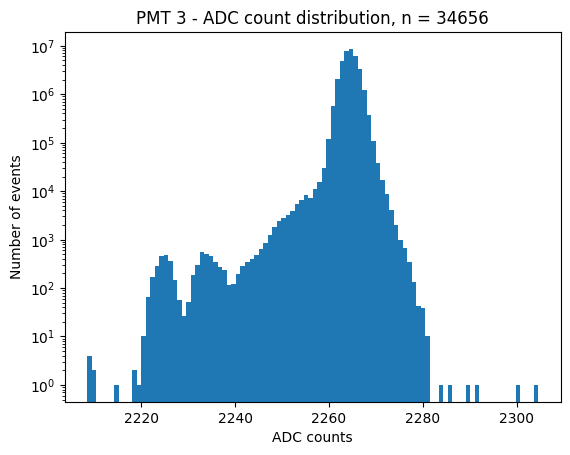

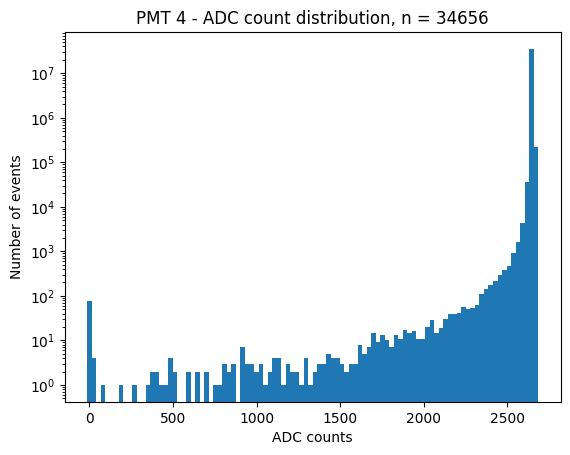

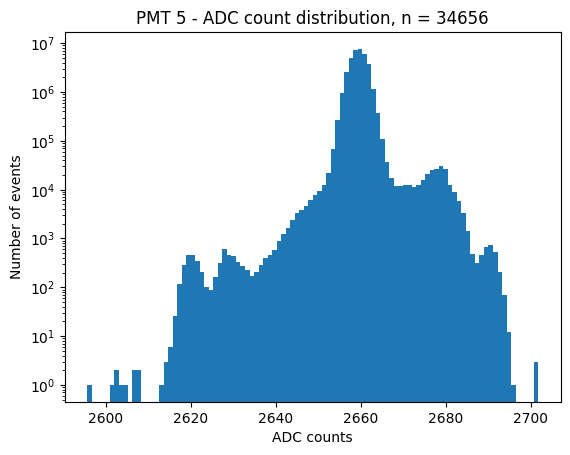

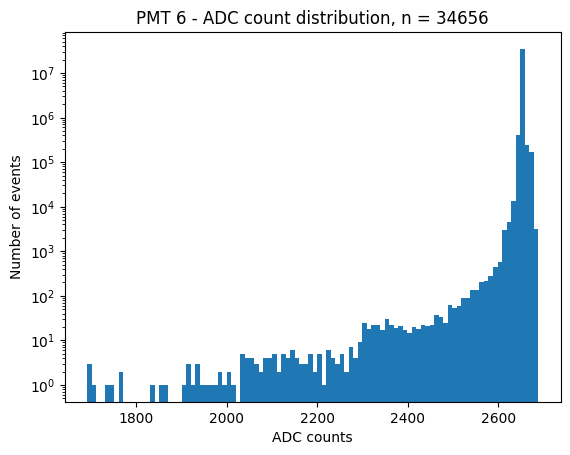

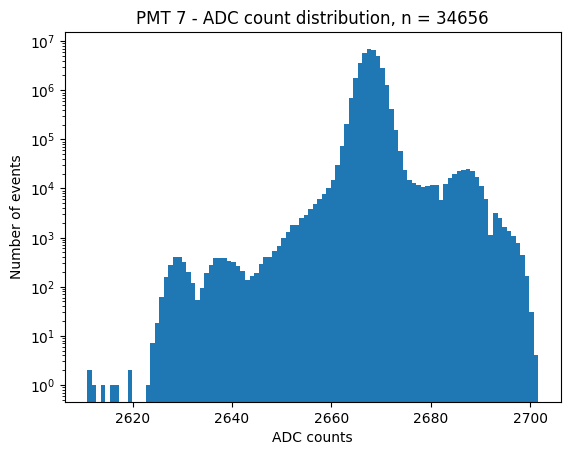

In [ ]:
for i in range(2,7):
  plot_hist_counts(data_june_29_arr[i], i+1, f"PMT {i+1} - ADC count distribution")
  print("")
# PMT 3 broken, just hovering around noise, wierd shape tho?
# PMT 5 & 7 also broken here???

# Testing, plotting, assigment notes

In [ ]:
true_index_june_30, peaks1, peaks2 = coincidence_finder(data_june_30_0, data_june_30_1) # 0 & 2 = top & distant (165cm)
print(true_index_june_30)
print(len(true_index_june_30))

In [ ]:
true_index_june_30, peaks1, peaks2 = coincidence_finder(data_june_30_0, data_june_30_2) # 0 & 2 = top & bottom
print(true_index_june_30)
print(len(true_index_june_30))

In [ ]:
true_index_june_30, peaks1, peaks2 = coincidence_finder(data_june_30_0, data_june_30_4) # 0 & 4-7 = top & PMT
print(true_index_june_30)
print(len(true_index_june_30))

In [ ]:
for i in range(1):
  plot_peak_area(data_june_30_arr, 4, true_index_june_30[i])

In [ ]:
area, samples, counts, baseline, baseline_std, threshold, pulse_start, pulse_end = peak_area(data_june_30_arr, 5, 1072)
print(pulse_start, pulse_end)

In [ ]:
for i in range(1):
  plot_signal(data_june_30_arr, [0,4], true_index_june_30[i])

In [ ]:
peak1, properties1 = find_peaks(data_june_30_arr[0][687], prominence=25, width=10)

peak2_list = []
for x in range(1024):
  peak2, properties2 = find_peaks(data_june_30_arr[2][687], prominence=25, width=10)
  peak2_list.append(peak/5)
print(peak1)
print(peak2_list)

In [ ]:
plot_signal(data_june_30_arr, [2], 687)
peak, prop = find_peaks(data_june_30_arr[2][687], prominence=25, width=10)
print(peak)
print(data_june_30_arr[2][687][peak])
plt.plot(peak*0.2, data_june_30_arr[2][687][57.6], "x", color = 'red')

[67, 70, 112, 188, 232, 341, 347, 393, 461, 525, 536, 541, 562, 583, 585, 585, 620, 627, 647, 664, 672, 672, 727, 767, 811, 830, 877, 877, 879, 896, 897, 915, 1014, 1051, 1118, 1124, 1142, 1161, 1173, 1307, 1391, 1433, 1464, 1480, 1487, 1512, 1512, 1522, 1530, 1552, 1568, 1663, 1669, 1669, 1760, 1761, 1843, 1847, 1889, 1905, 2098, 2132, 2215, 2223, 2264, 2310, 2346, 2410, 2410, 2473, 2502, 2502, 2503, 2524, 2618, 2626, 2639, 2669, 2747, 2791, 2827, 2830, 2945, 2945, 2954, 2954, 2998, 3251, 3253, 3271, 3296, 3343, 3378, 3378, 3378, 3504, 3567, 3611, 3646, 3660, 3679, 3690, 3756, 3764, 3768, 3782, 3821, 3828, 3915, 3994, 3997, 4012, 4114, 4138, 4190, 4194, 4197, 4252, 4263, 4306, 4306, 4321, 4392, 4392, 4395, 4421, 4431, 4512, 4562, 4573, 4612, 4630, 4630, 4756, 4776, 4826, 4839, 4915, 4999, 5000, 5019, 5028, 5040, 5047, 5101, 5109, 5110, 5151, 5161, 5161, 5192, 5212, 5289, 5311, 5396, 5434, 5495, 5514, 5524, 5524, 5544, 5580, 5587, 5590, 5676, 5720, 5778, 5801, 5838, 5838, 5915, 5999, 6

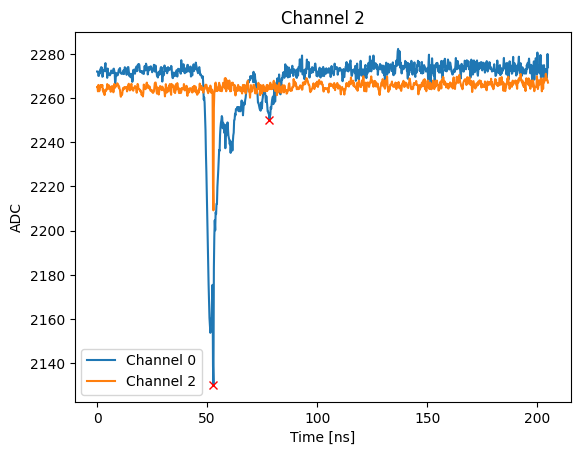

In [ ]:
# use this to find top and bottom events,
true_index_june_29, peaks1, peaks2 = coincidence_finder(data_june_29_0, data_june_29_2)
print(true_index_june_29)
print(len(true_index_june_29))
plot_signal(data_june_29_arr, [0,2], 67)
# check that peak detection and coincidince works correctly now, find index and amount of events with both plates

In [ ]:
'''
We have finding of pulses and calculating their area
Want to plot total pulse area of all PMTs combined (energy subsitiude) as function of min distance (need to substract stuff because overlapping)
How to add PMTs together (do we want this?, not all pmts have stuff, what if no peak)
  Is it better to just integrate entire sample?
  What if multiple peaks?, these are missed now I think, should they be (altough don't happen often worry about this later?)
Error margins?
Test single vs combined PMTs
Need to keep all else the same in between measurments, how to adjust for time? Average total pulse area over all measurements?
'''

"\nWe have finding of pulses and calculating their area\nWant to plot total pulse area of all PMTs combined (energy subsitiude) as function of min distance (need to substract stuff because overlapping)\nHow to add PMTs together (do we want this?, not all pmts have stuff, what if no peak)\n  Is it better to just integrate entire sample?\n  What if multiple peaks?, these are missed now I think, should they be (altough don't happen often worry about this later?)\nError margins?\nTest single vs combined PMTs\nNeed to keep all else the same in between measurments, how to adjust for time? Average total pulse area over all measurements?\n"

In [ ]:
'''
Number of events as function of total PMT area (energy) histogram and plot coincidence vs no coincidence for window data mostly (or compare to wall)
Want to do coincidence (between top and bottom) to make sure a particle or shower went through the PMTs (?)
  This means that we get lost of zeros on specific PMTs
  Do for indiv PMTs first!


  PMT gain different, to add to getter need to calibrate!!, different distacne different settings, better to do non perfect than not not at all.
'''

In [ ]:
true_index_june_30, peaks1, peaks2 = coincidence_finder(data_june_30_0, data_june_30_5) # 0 & 2 = top & bottom coin. events
print(true_index_june_30)
print(len(true_index_june_30))

In [12]:
def plot_signal(data_array, channels, event):
  for channel in channels:
      plt.plot(np.linspace(0, 204.8, num=1024), data_array[channel][event], label = f'Channel {channel}')
      peak, properties = find_peaks(-data_array[channel][event], prominence=25, width=10)

      if len(peak) != 0:
            plt.plot(peak*0.2, data_array[channel][event][peak], "x", color = 'red')
            print(f'Peak for channel {channel} is at: {peak[0]/5} ns.')
      else:
          print(f'No peak found for channel {channel}.')
  plt.xlabel('Time [ns]')
  plt.ylabel('ADC')
  plt.title(f'Channel {channel}')
  plt.legend(fontsize="10")
  plt.show()

In [ ]:
area_list_30 = []
for i in range(len(true_index_june_30)):
  total_area = peak_area(data_june_30_arr, 3, true_index_june_30[i])[0] + peak_area(data_june_30_arr, 4, true_index_june_30[i])[0] + peak_area(data_june_30_arr, 5, true_index_june_30[i])[0] + peak_area(data_june_30_arr, 6, true_index_june_30[i])[0]
  if total_area != 0:
    area_list_30.append(total_area)

In [ ]:
print(area_list_30)
print(len(area_list_30))

In [ ]:
plt.hist(area_list_30, log=True)
plt.title("PMT 4-7 total peak area histogram (top & bottom coincidence events)")
plt.xlabel("Area")
plt.ylabel("Number of events");

In [ ]:
true_index_june_29, peaks1, peaks2 = coincidence_finder(data_june_29_0, data_june_29_2) # 0 & 2 = top & bottom coin. events
print(true_index_june_29)
print(len(true_index_june_29))

area_list_29 = []
for i in range(len(true_index_june_29)):
  total_area = peak_area(data_june_29_arr, 5, true_index_june_29[i])[0]# + peak_area(data_june_29_arr, 5, true_index_june_29[i])[0]# + peak_area(data_june_29_arr, 5, true_index_june_29[i])[0] + peak_area(data_june_29_arr, 6, true_index_june_29[i])[0]
  if total_area != 0:
    area_list_29.append(total_area)

In [ ]:
print(len(area_list_29))
plt.hist(area_list_29, log=True)#, bins=20)
plt.ylim(0,200)
plt.xlim(0,100000)
# plt.ylim(100000)
plt.title("PMT 4 total peak area histogram (Wall, top & bottom coincidence events)")
plt.xlabel("Area")
plt.ylabel("Number of events");

In [ ]:
plt.hist(area_list_29, log=True)#, bins=20)
plt.title("PMT 6 total peak area histogram (Wall, top & bottom coincidence events)")
plt.xlabel("Area")
plt.ylabel("Number of events");

In [ ]:
print(len(area_list_29))

In [ ]:
plt.hist(area_list_29, log=True)#, bins=20)
plt.title("PMT 4 & 6 total peak area histogram (top & bottom coincidence events)")
plt.xlabel("Area")
plt.ylabel("Number of events");

In [ ]:
true_index_29_0_1, peaks1, peaks2 = coincidence_finder(data_june_29_0, data_june_29_1) # top & dist
true_index_29_0_2, peaks1, peaks2 = coincidence_finder(data_june_29_0, data_june_29_2) # top & bottom
true_index_29_either = np.union1d(true_index_29_0_1, true_index_29_0_2)
print(len(true_index_29_either))
print(len(data_june_29_0))

# Data compression, replaced with NIKHEF_make_short_data.ipynb

In [ ]:
# June 29th Wall - angle measurment
file_path_0 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/TR_0_0.txt" # top scint
file_path_1 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/wave_1.txt" # distant scint
file_path_2 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/wave_2.txt" # bottom scint
file_path_3 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/wave_3.txt" # PMT 3
file_path_4 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/wave_4.txt" # PMT 4
file_path_5 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/wave_5.txt" # PMT 5
file_path_6 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/wave_6.txt" # PMT 6
file_path_7 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/wave_7.txt" # PMT 7
file_paths = [file_path_1,file_path_2,file_path_3,file_path_4,file_path_5,file_path_6,file_path_7]

In [ ]:
def save_selected_sections(folder_locations, section_numbers):
    for folder in folder_locations:
        for root, dirs, files in os.walk(folder):
            for file in files:
                print(file)
                if file.endswith('SETUP_INFO.txt'):
                    continue  # Skip 'SETUP_INFO' file
                if file.endswith('.txt'):
                    file_name = os.path.splitext(file)[0]  # Remove '.txt' extension
                    output_file = file_name + "_selected.txt"  # Output file name without duplicate '.txt'

                    input_file = os.path.join(root, file)
                    output_file = os.path.join(root, output_file)

                    with open(input_file, 'r') as file:
                        lines = file.readlines()

                    selected_sections = []
                    for section_num in section_numbers:
                        start_line = (section_num - 1) * 1032
                        end_line = start_line + 1032
                        selected_sections.extend(lines[start_line:end_line])

                    with open(output_file, 'w') as file:
                        file.writelines(selected_sections)


In [ ]:
# for file_path in file_paths:
folder_locations = ["/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate"]
save_selected_sections(folder_locations, true_index_29_either)


In [ ]:
# June 29th Wall - angle measurment - selected
file_path_0 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/TR_0_0_selected.txt" # top scint
file_path_1 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/wave_1_selected.txt" # distant scint
file_path_2 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/wave_2_selected.txt" # bottom scint
file_path_3 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/wave_3_selected.txt" # PMT 3
file_path_4 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/wave_4_selected.txt" # PMT 4
file_path_5 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/wave_5_selected.txt" # PMT 5
file_path_6 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/wave_6_selected.txt" # PMT 6
file_path_7 = "/content/drive/MyDrive/Nikhef_project/DATA/June 29 angle plate/wave_7_selected.txt" # PMT 7
file_paths = [file_path_1,file_path_2,file_path_3,file_path_4,file_path_5,file_path_6,file_path_7]

data_june_29_0 = read_data_from_file(file_path_0);
data_june_29_1 = read_data_from_file(file_path_1);
data_june_29_2 = read_data_from_file(file_path_2);
data_june_29_3 = read_data_from_file(file_path_3);
data_june_29_4 = read_data_from_file(file_path_4);
data_june_29_5 = read_data_from_file(file_path_5);
data_june_29_6 = read_data_from_file(file_path_6);
data_june_29_7 = read_data_from_file(file_path_7);

data_june_29_arr = np.array([data_june_29_0, data_june_29_2, data_june_29_3, data_june_29_4, data_june_29_5, data_june_29_6, data_june_29_7])

In [ ]:
true_index_29_0_1_selected, peaks1, peaks2 = coincidence_finder(data_june_29_0, data_june_29_1) # top & distant
true_index_29_0_2_selected, peaks1, peaks2 = coincidence_finder(data_june_29_0, data_june_29_2) # top & bottom
# total :836
#total all:34647
print(len(true_index_29_0_1_selected)+len(true_index_29_0_1_selected))

In [ ]:
plot_signal(data_june_29_arr, [0,1,2], 3)

In [ ]:
print(len(data_june_29_0))
print(len(true_index_29_either))

In [ ]:
# aantal is correct (-1 van read file), maar om een of ander rede geen piek meer, kan er nog even kort naar kijken
# anders idee laten zitten gewoon wat langer laten laden?, maakt het wel lastiger voor aanpassingen..
# sowieso eerst test data gebruiken, dan in tussentijd laten runnen op laptop met grotere data sets...


In [ ]:
# for file_path in file_paths:
folder_locations = ["/content/drive/MyDrive/Nikhef_project/DATA/June 30 window measurment"]
save_selected_sections(folder_locations, [0])

In [ ]:
true_index_week_0_1, peaks1, peaks2 = coincidence_finder(data_array_0, data_array_2)  # top & bottom
print(len(true_index_week_0_1))
print((true_index_week_0_1))

In [ ]:
folder_locations = ["/content/drive/MyDrive/Nikhef_project/Weekend_data/"]
save_selected_sections(folder_locations, [8,33])

In [ ]:
file_path_0_selected = "/content/drive/MyDrive/Nikhef_project/Weekend_data/TR_0_0_selected.txt"
file_path_2_selected = "/content/drive/MyDrive/Nikhef_project/Weekend_data/wave_2_selected.txt"

data_array_0_selected = read_data_from_file(file_path_0_selected)
data_array_2_selected = read_data_from_file(file_path_2_selected)
data_test = np.array([data_array_0_selected,  data_array_2_selected])
true_index_week_0_1_selected, peaks1, peaks2 = coincidence_finder(data_array_0_selected, data_array_2_selected)  # top & bottom
print(len(true_index_week_0_1_selected))
print((true_index_week_0_1_selected))

# Peak amplitude 1 SPE

In [13]:
# sets threshold, calculates area of peak

def peak_amplitude(data_arr_arr, channel, event):
  counts = data_arr_arr[channel][event] # ADC counts
  samples = np.arange(len(counts)) # number of samples
  baseline_section = np.concatenate((counts[:200], counts[-500:-30]))    # make this so it checks that there is not a pulse here, can be now we have multiple messing with baseline
  baseline = np.median(baseline_section) # median of the non trigger region, should be non pulse region
  baseline_std = np.std(baseline_section) # standard deviation of baseline region

  threshold = [(baseline - 3 * baseline_std)] * len(samples) # number of std is kind of arbitary still for now, high for now as we don't seperate peaks yet: decide, be consistent and explain justification
                                                                    # also need to decide if we want just single peak or not, now it accepts multiple --> don't want this.
  threshold =  threshold - baseline
  counts = counts - baseline # redefine baseline as zero

  amplitudes = []
  peaks, properties = find_peaks(-counts, prominence=30, width=10)

  if len(peaks) != 0:
    for peak in peaks:
      amplitude = -counts[peak]
      amplitudes.append(amplitude)
  else:
      amplitudes, pulse_start, pulse_end = 0,0,0

  return amplitudes#, peak, samples, counts, baseline, baseline_std, threshold, pulse_start, pulse_end

In [14]:
# sets threshold, calculates area of peak, this is only for dark counts now!

def peak_area_all(data_arr_arr, channel, event):
  counts = data_arr_arr[channel][event] # ADC counts
  samples = np.arange(len(counts)) # number of samples
  baseline_section = np.concatenate((counts[:200], counts[-500:-30]))    # make this so it checks that there is not a pulse here, can be now we have multiple messing with baseline
  baseline = np.median(baseline_section) # median of the non trigger region, should be non pulse region
  baseline_std = np.std(baseline_section) # standard deviation of baseline region

  threshold = [(baseline - 3 * baseline_std)] * len(samples) # number of std is kind of arbitary still for now, high for now as we don't seperate peaks yet: decide, be consistent and explain justification
                                                                    # also need to decide if we want just single peak or not, now it accepts multiple --> don't want this?
  threshold =  threshold - baseline
  counts = counts - baseline # redefine baseline as zero

  areas = []
  peaks, properties = find_peaks(-counts, prominence=18, width=12)

  if len(peaks) != 0:
    for i in range(len(peaks)):
      # print(properties.get('widths')[i]/2)
      # pulse_start = math.floor(peaks[i] - properties.get('widths')[i]/2) - 1
      # pulse_end   = math.ceil (peaks[i] + properties.get('widths')[i]/2) - 1      # these widths need to be constant to compare areas better!
      pulse_start = math.floor(peaks[i]) - 10
      pulse_end = math.floor(peaks[i]) + 10   #constant window around peak center, might need to chance range, will only work for dark counts now!

      area = abs(np.trapz(counts[pulse_start:pulse_end], samples[pulse_start:pulse_end]))

      areas.append(area)
  else:
      area, pulse_start, pulse_end = 0,0,0

  return areas#, peak, samples, counts, baseline, baseline_std, threshold, pulse_start, pulse_end

In [15]:
def plot_signal(data_array, channels, event):
  for channel in channels:
      plt.plot(np.linspace(0, 204.8, num=1024), data_array[channel][event], label = f'Channel {channel}')
      peak, properties = find_peaks(-data_array[channel][event], prominence=18, width=12)
      if len(peak) != 0:
            plt.plot(peak*0.2, data_array[channel][event][peak], "x", color = 'red')
            print(f'Peak for channel {channel} is at: {peak[0]/5} ns.')
      else:
          print(f'No peak found for channel {channel}.')
  plt.xlabel('Time [ns]')
  plt.ylabel('ADC')
  plt.title(f'Channel {channel}')
  plt.legend(fontsize="10")
  plt.show()

In [ ]:
true_index_29_0_4, peaks1, peaks2 = coincidence_finder(data_june_29_0, data_june_29_4)
print(true_index_29_0_4)
print(len(true_index_29_0_4))

[30, 63, 272, 461, 527, 592, 1014, 1051, 1218, 1257, 1487, 1531, 1699, 1731, 1760, 1808, 1843, 1847, 2149, 2153, 2153, 2264, 2267, 2294, 2310, 2346, 2410, 2410, 2473, 2502, 2512, 2537, 2626, 2711, 2791, 2936, 2945, 2945, 2954, 3024, 3161, 3270, 3322, 3369, 3642, 3679, 3717, 3814, 3821, 3955, 3994, 3999, 4014, 4144, 4263, 4306, 4321, 4414, 4431, 4470, 4584, 4612, 4753, 4756, 4780, 4815, 4834, 4891, 4921, 4999, 5019, 5047, 5109, 5229, 5268, 5341, 5470, 5524, 5676, 5767, 5782, 5786, 5838, 5859, 5915, 6023, 6023, 6042, 6049, 6249, 6339, 6387, 6486, 6508, 6524, 6524, 6533, 6554, 6590, 6617, 6767, 6880, 6931, 6943, 6943, 6943, 6999, 7027, 7039, 7093, 7156, 7191, 7225, 7240, 7272, 7296, 7332, 7522, 7522, 7653, 7679, 8001, 8028, 8039, 8041, 8126, 8132, 8137, 8218, 8240, 8324, 8388, 8398, 8410, 8424, 8520, 8563, 8601, 8617, 8625, 8657, 8685, 8743, 8797, 8852, 8921, 8944, 9049, 9070, 9072, 9181, 9218, 9300, 9385, 9425, 9495, 9500, 9500, 9502, 9503, 9509, 9515, 9524, 9530, 9545, 9552, 9555, 9558,

No peak found for channel 4.


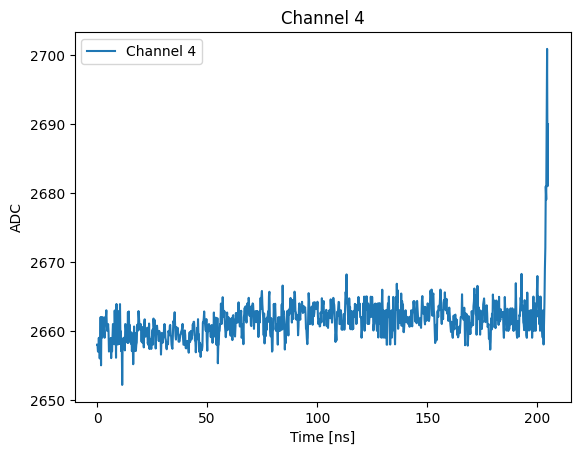

areas_all []
areas 0
amplitude 0

Peak for channel 4 is at: 47.8 ns.


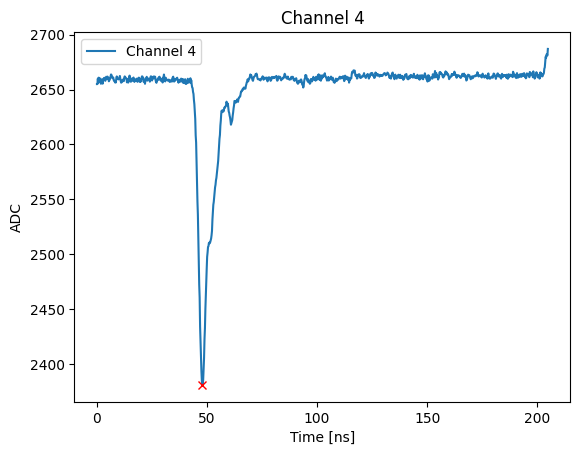

areas_all [4366.179313999998]
areas 10177.49372649999
amplitude [280.4920649999999]

No peak found for channel 4.


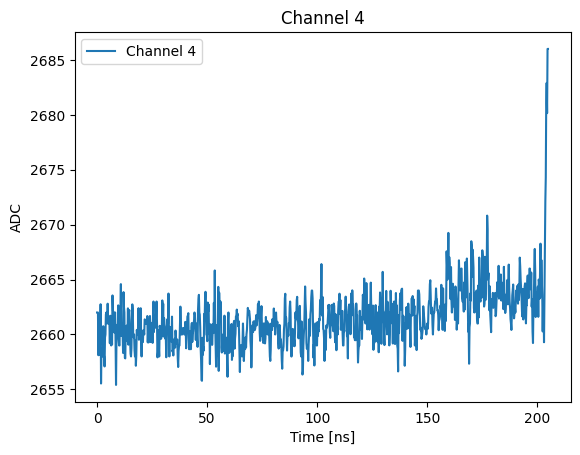

areas_all []
areas 0
amplitude 0

Peak for channel 4 is at: 47.8 ns.


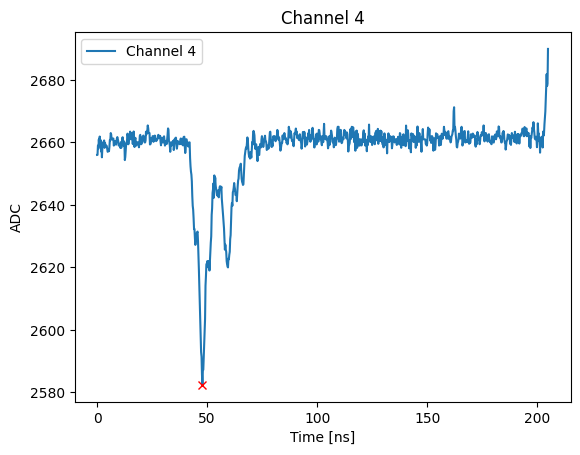

areas_all [1116.2988295000005, 644.5822759999999]
areas 3493.1021755000006
amplitude [78.60107400000015]

Peak for channel 4 is at: 49.6 ns.


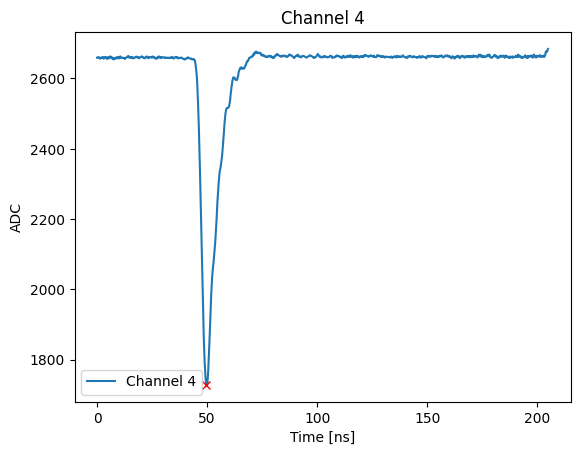

areas_all [15873.213443999999, 8.77014600000075]
areas 37165.8480545
amplitude [932.8323975000001]



In [ ]:
# amplitude test
channel, event = 4, 9 # in true index
for i in range(5):
  event = true_index[i]
  amplitude = peak_amplitude(data_arr_arr, channel, event) #, peak, samples, counts, baseline, baseline_std, threshold, pulse_start, pulse_end =
  plot_signal(data_arr_arr, [channel], event)
  areas_all = peak_area_all(data_arr_arr, channel, event)
  areas = peak_area(data_arr_arr, channel, event)
  print("areas_all", areas_all)
  print("areas", areas[0])
  print("amplitude", amplitude)
  print("")

In [ ]:
area_list_29_PMT4 = []
for i in range(len(data_june_29_arr[4])):
  areas = peak_area_all(data_june_29_arr, 4, i)
  if len(areas) != 0:
    for area in areas:
        if area < 2000: #1200
          area_list_29_PMT4.append(area)

In [ ]:
print(len(data_june_29_arr[4]))
print(len(area_list_29_PMT4))

34656
1642


1642
[129 844 391 127  57  28  16  17  22  11]
[   3.528074   202.1263045  400.724535   599.3227655  797.920996
  996.5192265 1195.117457  1393.7156875 1592.313918  1790.9121485
 1989.510379 ]


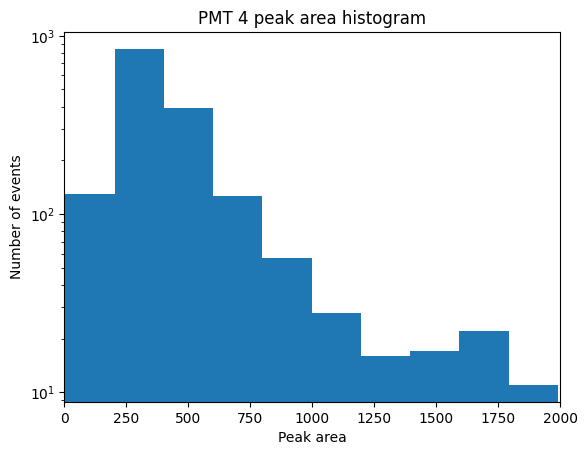

In [ ]:
print(len(area_list_29_PMT4))

hist, bins = np.histogram(area_list_29_PMT4)
plt.hist(area_list_29_PMT4, log=True, bins=bins)
plt.xlim(0,2000)
plt.title("PMT 4 peak area histogram")
plt.xlabel("Peak area") #integrated charge [mV*ns]
plt.ylabel("Number of events");
print(hist)
print(bins)

10 10


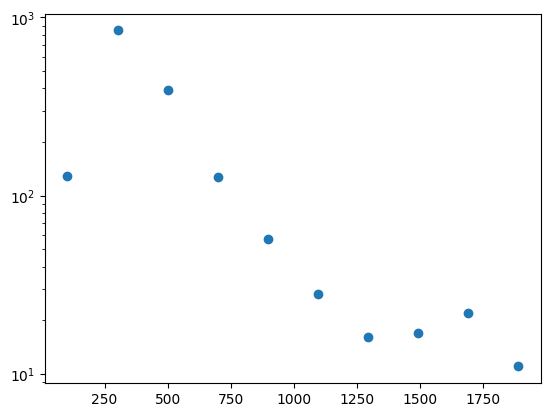

In [ ]:
# plt.plot(x, gaussian(x, 1,1,5,15,0.1,0.1), 'r-', label='Actuall Gaussian')
centers = (bins[:-1] + bins[1:]) / 2  # bin centers
print(len(centers), len(hist))
plt.yscale('log')
plt.scatter(centers, hist)

In [ ]:
# Generate Gaussian function for fitting 1 SPE dark counts calibration
def gaussian(x, amp, mu, sigma):
    return amp/(sigma*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mu)/sigma)**2)

def gaussian_double(x, amp1, amp2, mu1, mu2, sigma1, sigma2):
    return amp1/(sigma1*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mu1)/sigma1)**2) + amp2/(sigma2*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mu2)/sigma2)**2)

def gaussian_triple(x, amp1, amp2, amp3, mu1, sigma1, sigma2, sigma3):
    return amp1/(sigma1*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mu1)/sigma1)**2) + amp2/(sigma2*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-2*mu1)/sigma2)**2) + amp3/(sigma3*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-3*mu1)/sigma3)**2)

amp1_0 = 150000
amp2_0 = 12000
amp3_0 = 38000
mu1_0 = 300
sigma1_0 = 100
sigma2_0 = 225
sigma3_0 = 250
param_bounds = ([0,0,15000,100,50,50,50], [300000, 200000, 200000,1000, 500,500,1000])  # lower and upper bounds
p0 = [amp1_0, amp2_0, amp3_0, mu1_0, sigma1_0, sigma2_0, sigma3_0]
params, _ = curve_fit(gaussian_triple, centers, hist, p0=p0, bounds=param_bounds)

# Plot fitted Gaussian function
x = np.linspace(min(centers)-100, max(centers)+100, 1000)
plt.plot(x, gaussian(x, params[0], params[3], params[4]) + gaussian(x, params[1], params[3], params[5]) + gaussian(x, params[2], params[3], params[6]), label='Total')

plt.plot(x, gaussian(x, params[0], params[3],   params[4]), label=f'$\mu_1$ = {params[3]:.2f},   $\sigma_1 = $ {params[4]:.2f}')
plt.plot(x, gaussian(x, params[1], 2*params[3], params[5]), label=f'$\mu_2$ = {2*params[3]:.2f}, $\sigma_2 = $ {params[5]:.2f}')
plt.plot(x, gaussian(x, params[2], 3*params[3], params[6]), label=f'$\mu_3$ = {3*params[3]:.2f}, $\sigma_3 = $ {params[6]:.2f}')
# plt.plot(x, gaussian(x, amp3_0, 3*329, sigma3_0))

plt.scatter(centers, hist, c='red')
plt.hist(area_list_29_PMT4, log=True, bins=bins)

plt.ylim(1, 1e3)
plt.xlim(0, 1500)
print(params)
print(f'1SPE: {params[3]:.2f}')
print(f'2: {2*params[3]:.2f}')
print(f'3: {3*params[3]:.2f}')

# Show the plot
plt.legend();
plt.xlabel('Peak area [change to mV*ns]')
plt.yscale('log')
plt.title('PMT 4 Calibration')
plt.ylabel('Counts')
plt.show();


# [should mu1 = 2 * mu2 or is this not needed?, right now it is, seems to be the case with V..?]
# log axis can be a bit deciving, check normal also
# need to try it with much larger data set once the compression works, then tweek code some more.
# could add all datasets for a single pmt together, if all settings are the same between them as they should be etc.

472
[ 39 259  74  31  19  16  21   1   6   6]
[6.00216000e-01 1.48660324e+02 2.96720431e+02 4.44780539e+02
 5.92840647e+02 7.40900754e+02 8.88960862e+02 1.03702097e+03
 1.18508108e+03 1.33314118e+03 1.48120129e+03]


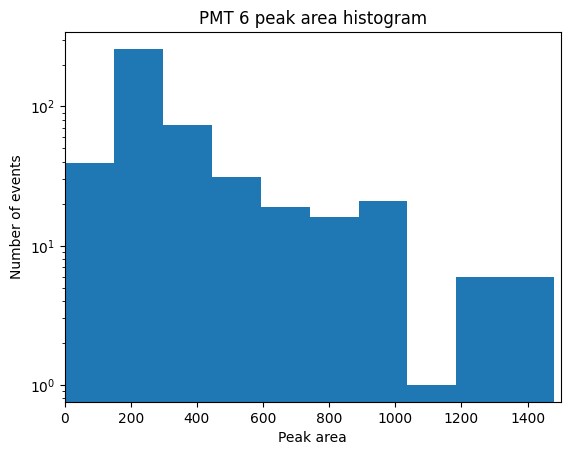

In [ ]:
n = 6
area_list_29_PMT6 = []
for i in range(len(data_june_29_arr[n])):
  areas = peak_area_all(data_june_29_arr, n, i)
  if len(areas) != 0:
    for area in areas:
        if area < 1500:
          area_list_29_PMT6.append(area)

print(len(area_list_29_PMT6))

hist, bins = np.histogram(area_list_29_PMT6)
plt.hist(area_list_29_PMT6, log=True, bins=bins)
plt.xlim(0, 1500)
plt.title(f"PMT {n} peak area histogram")
plt.xlabel("Peak area") #i ntegrated charge [mV*ns]
plt.ylabel("Number of events");
print(hist)
print(bins)
centers = (bins[:-1] + bins[1:]) / 2

In [ ]:
amp1_0 = 150000
amp2_0 = 12000
amp3_0 = 38000
mu1_0 = 300
sigma1_0 = 100
sigma2_0 = 225
sigma3_0 = 250
param_bounds = ([0,0,15000,100,50,50,50], [300000, 200000, 200000,1000, 500,500,1000])  # lower and upper bounds
p0 = [amp1_0, amp2_0, amp3_0, mu1_0, sigma1_0, sigma2_0, sigma3_0]
params, _ = curve_fit(gaussian_triple, centers, hist, p0=p0, bounds=param_bounds)

# Plot fitted Gaussian function
x = np.linspace(min(centers)-100, max(centers)+100, 1000)
plt.plot(x, gaussian(x, params[0], params[3], params[4]) + gaussian(x, params[1], params[3], params[5]) + gaussian(x, params[2], params[3], params[6]), label='Total')

plt.plot(x, gaussian(x, params[0], params[3],   params[4]), label=f'$\mu_1$ = {params[3]:.2f},   $\sigma_1 = $ {params[4]:.2f}')
plt.plot(x, gaussian(x, params[1], 2*params[3], params[5]), label=f'$\mu_2$ = {2*params[3]:.2f}, $\sigma_2 = $ {params[5]:.2f}')
plt.plot(x, gaussian(x, params[2], 3*params[3], params[6]), label=f'$\mu_3$ = {3*params[3]:.2f}, $\sigma_3 = $ {params[6]:.2f}')
# plt.plot(x, gaussian(x, amp3_0, 3*329, sigma3_0))

plt.scatter(centers, hist, c='red')
plt.hist(area_list_29_PMT6, log=True, bins=bins)

plt.ylim(1, 1e3)
plt.xlim(0, 1500)
print(params)
print(f'1SPE: {params[3]:.2f}')
print(f'2: {2*params[3]:.2f}')
print(f'3: {3*params[3]:.2f}')

# Show the plot
plt.legend();
plt.xlabel('Peak area [change to mV*ns]')
plt.yscale('log')
plt.title('PMT 6 Calibration')
plt.ylabel('Counts')
plt.show();

# Old SPE test

RuntimeError: ignored

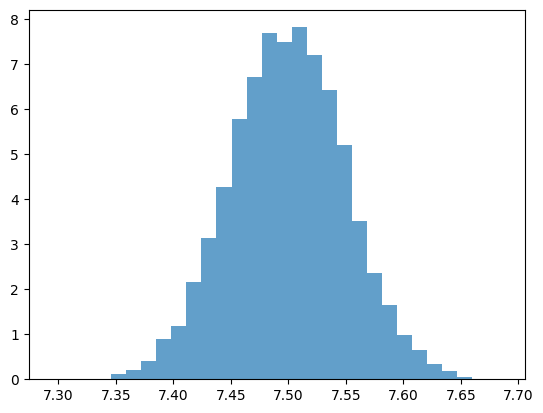

In [ ]:
# Generate Gaussian function
def gaussian(x, amp1, amp2, mu1, mu2, sigma1, sigma2):
    return amp1/(sigma1*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mu1)/sigma1)**2) + amp2/(sigma2*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mu2)/sigma2)**2)


# Generate random data following a Gaussian distribution
mu1 = 5  # mean
mu2 = 15

sigma1 = 0.1 # standard deviation
sigma2 = 0.1
amp1 = 0.5
amp2 = 0.5
data1 = amp1 * np.random.normal(mu1, sigma1, 10000)
data = amp2 * np.random.normal(mu2, sigma2, 10000)


# data2 = amp2 * np.random.normal(mu2, sigma2, 10000)
# data = data1 + data2
# data1 = np.array([10]*5000)
# data = np.array([0]*5000 + [-1]*2500 + [1*2500])
# data = data1 + data2
# Plot histogram of the data
plt.hist(data, bins=30, density=True, alpha=0.7)

# Fit Gaussian function to the histogram
bins, edges = np.histogram(data, bins=30, density=True)
centers = (edges[:-1] + edges[1:]) / 2  # bin centers
params, _ = curve_fit(gaussian, centers, bins)

# Plot fitted Gaussian function
x = np.linspace(min(data), max(data), 100)
plt.plot(x, gaussian(x, *params), 'r-', label='Fitted Gaussian')
print(params)

# Show the plot
plt.legend()
plt.xlabel('x')
# plt.yscale('log')
plt.ylabel('Probability')
plt.show()

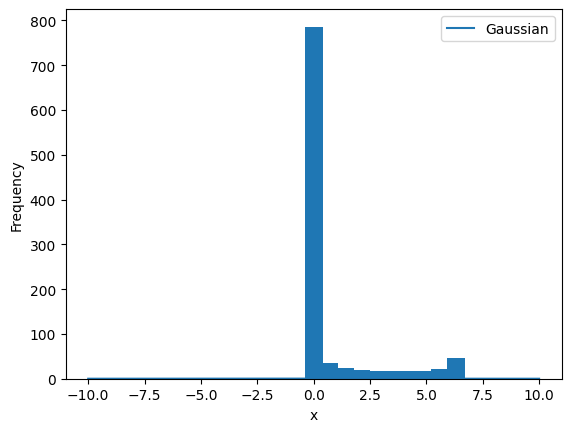

[3. 1. 7.]


In [ ]:
def Gaussian(x, mu, sig, a):
    return a * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) #+ a * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))


x = np.linspace(-10, 10, 1000)
hist, bins = np.histogram(Gaussian(x, 3, 2, 7))

# Generate x-values for the fitted parabola
x_fit = np.linspace(-10, 10, 1000)
y_Gauss = Gaussian(x_fit, 3, 1, 7)

hist, bins = np.histogram(y_Gauss)

# Fit the parabola to the histogram data
params, _ = curve_fit(Gaussian, x, y_Gauss, p0=np.asarray([1,1,2]))



# Evaluate the fitted parabola at the x-values
# y_fit = parabola(x_fit, *params)


# Plotting the histogram and fitted parabola
# plt.bar(bins[:-1], hist, width=np.diff(bins), align='edge', color='gray', alpha=0.5, label='Histogram', log=False)
# plt.plot(x_fit, y_fit, color='red', label='Fitted function', )
plt.bar(bins[:-1], hist)
plt.plot(x_fit, y_Gauss, label='Gaussian')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(params)


In [ ]:
hist, bins = np.histogram(area_list_29_PMT4)
print(hist)

# Define the function to fit (parabola)
def parabola(x, a, b, c):
    return a * x**2 + b * x + c

def Gaussian(x, mu, sig, a):
    return a * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) #+ a * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))


x = np.linspace(0, 100, 1000)
hist, bins = np.histogram(Gaussian(x, 3, 2, 700))


# Fit the parabola to the histogram data
params, _ = curve_fit(Gaussian, bins[:-1], hist, p0=np.asarray([300, 200, 700]))

# Generate x-values for the fitted parabola
x_fit = np.linspace(min(bins), max(bins), 1000)
# Evaluate the fitted parabola at the x-values
y_fit = parabola(x_fit, *params)

y_Gauss = Gaussian(x_fit, 300, 200, 900)

# Plotting the histogram and fitted parabola
plt.bar(bins[:-1], hist, width=np.diff(bins), align='edge', color='gray', alpha=0.5, label='Histogram', log=False)
plt.plot(x_fit, y_fit, color='red', label='Fitted function', )
# plt.plot(x_fit, y_Gauss, label='Gaussian')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(params)



[  14  544 1082  774  316  166  114   64   36   17]


RuntimeError: ignored

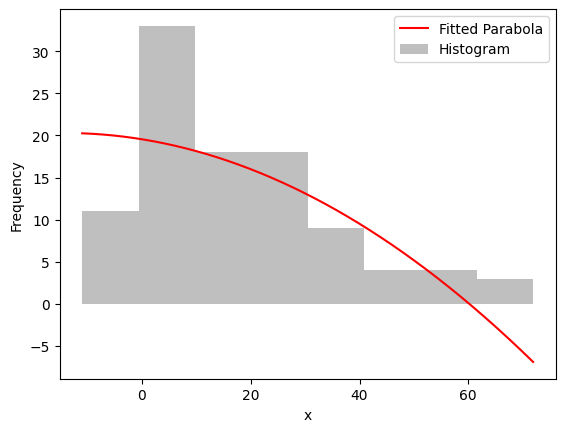

In [ ]:
# Generate histogram data
x = np.linspace(-5, 5, 100)
y = 2*x**2 + 3*x + 1 + np.random.normal(0, 5, 100)
hist, bins = np.histogram(y, bins='auto')

# Define the function to fit (parabola)
def parabola(x, a, b, c):
    return a * x**2 + b * x + c

# Fit the parabola to the histogram data
params, _ = curve_fit(parabola, bins[:-1], hist)

# Generate x-values for the fitted parabola
x_fit = np.linspace(min(bins), max(bins), 1000)

# Evaluate the fitted parabola at the x-values
y_fit = parabola(x_fit, *params)

# Plotting the histogram and fitted parabola
plt.bar(bins[:-1], hist, width=np.diff(bins), align='edge', color='gray', alpha=0.5, label='Histogram')
plt.plot(x_fit, y_fit, color='red', label='Fitted Parabola')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Folder with data to data array

In [ ]:
area_list_3_PMT4 = []
for i in range(len(data_june_29_arr[5])):
  areas = peak_area_all(data_june_29_arr, 3, i)
  if len(areas) != 0:
    for area in areas:
        if area < 1000:
          area_list_29_PMT4.append(area)

In [16]:
def folder_to_array(folder_path):
    # Get a list of files in the folder
    file_list = os.listdir(folder_path)

    # Initialize a dictionary to store the data arrays
    data_dict = {}
    data_arr_arr = []

    # Iterate through each file in the folder
    for file_name in file_list:
        # Create the full file path
        file_path = os.path.join(folder_path, file_name)

        # Check if the file is a regular file (not a folder etc.)
        if os.path.isfile(file_path):
            # Apply the read_data_from_file function to the file
            data_array = read_data_from_file(file_path)
            data_arr_arr.append(data_array)

            # # Store the data array with the name equal to the filepath
            # data_dict[file_name] = data_array

    return np.array(data_arr_arr)

# Shorter dataset test

In [ ]:
data_dict_july_3_short = folder_to_array("/content/drive/MyDrive/Nikhef_project/Short_DATA/July 3 100cm")

In [ ]:
# print(data_dict_july_3_short['short_7.txt'])
print(len(data_dict_july_3_short['short_7.txt']))

In [ ]:
print(data_dict_july_3_short.shape)

(8, 188, 1024)


Peak for channel 0 is at: 35.4 ns.
Peak for channel 1 is at: 55.6 ns.


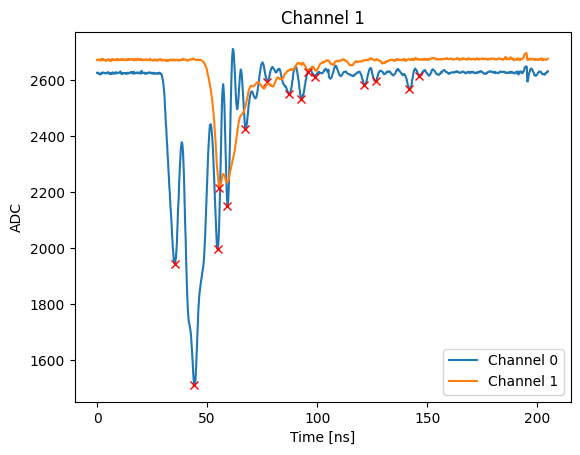

In [ ]:
# for i in range(2):
plot_signal(data_dict_july_3_short, [0,1], 5);
  # print("")

In [ ]:
true_index_july_3, peaks1, peaks2 = coincidence_finder(data_dict_july_3_short[0], data_dict_july_3_short[1]) # 0 & 2 = top & bottom coin. events
print(true_index_july_3)
print(len(true_index_july_3))

[5, 5, 5, 5, 12, 12, 12, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 23, 23, 23, 23, 23, 30, 30, 30, 30, 30, 30, 30, 32, 32, 32, 32, 37, 37, 38, 38, 38, 39, 39, 39, 39, 42, 42, 42, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 50, 50, 51, 56, 57, 58, 58, 59, 67, 70, 70, 70, 76, 77, 77, 78, 78, 78, 78, 78, 78, 79, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 82, 82, 83, 83, 83, 85, 85, 85, 85, 85, 85, 92, 92, 93, 93, 93, 93, 93, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 99, 99, 99, 99, 99, 100, 100, 101, 101, 103, 106, 106, 106, 106, 108, 108, 112, 112, 112, 112, 113, 113, 115, 115, 115, 115, 115, 116, 116, 116, 116, 116, 116, 116, 117, 118, 118, 118, 118, 118, 118, 119, 119, 119, 119, 120, 120, 122, 127, 127, 127, 127, 127, 127, 127, 128, 128, 128, 128, 128, 128, 128, 128, 129, 

In [ ]:
print(true_index_june_29)
print(len(true_index_june_29))

area_list_29 = []
for i in range(len(true_index_june_29)):
  total_area = peak_area(data_june_29_arr, 5, true_index_june_29[i])[0]# + peak_area(data_june_29_arr, 5, true_index_june_29[i])[0]# + peak_area(data_june_29_arr, 5, true_index_june_29[i])[0] + peak_area(data_june_29_arr, 6, true_index_june_29[i])[0]
  if total_area != 0:
    area_list_29.append(total_area)

plt.hist(area_list_29, log=True)#, bins=20)
plt.title("PMT 6 total peak area histogram (Wall, top & bottom coincidence events)")
plt.xlabel("Area")
plt.ylabel("Number of events");

# Event rate plot

In [ ]:
'''
Event rate as function of distance plot:
Take minimal shower size and timeframe from folder name
take number of coincidence events between top and distance and plot

For event rate we just want the single file 'distant.txt' and divide number of lines by 1032 to get number of peaks
'''

In [17]:
def calc_event_rate(folder_path):
    # Extract information from the folder name using regular expressions
    folder_name = os.path.basename(folder_path)
    split_strings = folder_name.split(" ")

    position    = split_strings[2]        # wall vs window
    shower_size = float(split_strings[3]) # cm
    timeframe   = float(split_strings[5]) # hours

    # Count the number of lines in the 'distant.txt' file (peak in both top and distant plate)
    file_path = folder_path + "/distant.txt"
    try:
        with open(file_path, 'r') as file:
            num_lines = len(file.readlines())
    except FileNotFoundError:
        # Return None if the file doesn't exist
        return None

    # Calculate num_peaks by dividing the number of lines by 1024 (# samples / event)
    num_peaks  = num_lines / 1024
    event_rate = num_peaks / timeframe

    # Return the extracted information
    return timeframe, shower_size, position, num_peaks, event_rate

In [ ]:
# Test calc_event_rate(folder_path)

directory_path = "/content/drive/MyDrive/Nikhef_project/Short_DATA/"

for folder_name in os.listdir(directory_path):
  folder_path = os.path.join(directory_path, folder_name)
  result = calc_event_rate(folder_path)
  if result is not None:
      timeframe, shower_size, position, num_peaks, event_rate = result
      print(f"Timeframe: {timeframe} hours")
      print(f"Minimal shower size: {shower_size} cm")
      print("Setup position:", position)
      print("Number of peaks:", num_peaks)
      print(f"Event rate: {event_rate:.2f} / hour")
      print(" ")
  else:
      print("File name not found.")

In [ ]:
directory_path = "/content/drive/MyDrive/Nikhef_project/Short_DATA/"

angle_window_shower_sizes = []
angle_window_event_rates = []
angle_wall_shower_sizes = []
angle_wall_event_rates = []

flat_window_shower_sizes = []
flat_window_event_rates = []
flat_wall_shower_sizes = []
flat_wall_event_rates = []

for folder_name in os.listdir(directory_path):
    folder_path = os.path.join(directory_path, folder_name)
    result = calc_event_rate(folder_path)
    timeframe, shower_size, position, num_peaks, event_rate = result

    if position == "angle_window":
        angle_window_shower_sizes.append(shower_size)
        angle_window_event_rates.append(event_rate)

        if event_rate > 1000:
          print(event_rate, folder_path)  # july 11 rate very high, also crashed DAQ, timeframe might be wrong?

    elif position == "angle_wall":
        angle_wall_shower_sizes.append(shower_size)
        angle_wall_event_rates.append(event_rate)
    elif position == "flat_window":
        flat_window_shower_sizes.append(shower_size)
        flat_window_event_rates.append(event_rate)
    elif position == "flat_wall":
        flat_wall_shower_sizes.append(shower_size)
        flat_wall_event_rates.append(event_rate)

1440.9475465313028 /content/drive/MyDrive/Nikhef_project/Short_DATA/July 11 angle_window 439 cm 11.82 hours


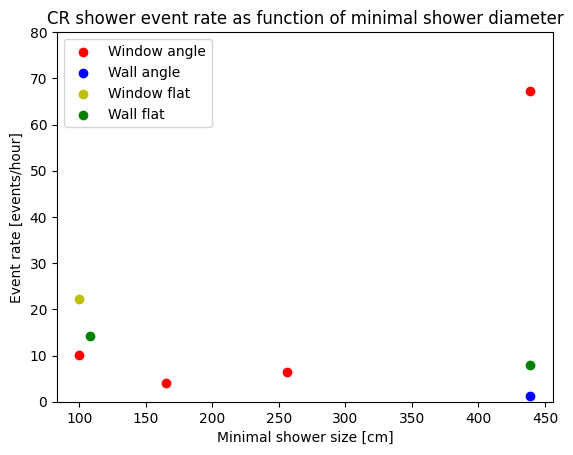

In [ ]:
plt.scatter(angle_window_shower_sizes, angle_window_event_rates, label = "Window angle", c='r')
plt.scatter(angle_wall_shower_sizes,   angle_wall_event_rates,   label = "Wall angle" , c='b')
plt.scatter(flat_window_shower_sizes,  flat_window_event_rates,  label = "Window flat", c='y')
plt.scatter(flat_wall_shower_sizes,    flat_wall_event_rates,    label = "Wall flat"  , c='g')

plt.ylim(0,80) # july 11 rate very high, also crashed DAQ, timeframe might be wrong? Excluded from plot for now, --> discussion

plt.xlabel("Minimal shower size [cm]")
plt.ylabel("Event rate [events/hour]")
plt.title("CR shower event rate as function of minimal shower diameter")
plt.legend()
plt.show()

# include errors, time frame quite accurate if correct, event rate more or less exact, Poisson sqrt(N) stat error?
# remove dark counts?, peak promininance or amplitdue higher?, hard tho, don't want to miss out on data?, dark count rate stable and small enough?

In [ ]:
# July 4 window 100 cm flat
file_path_0 = "/content/drive/MyDrive/Nikhef_project/Short_DATA/July 4 flat_window 100 cm 49.08 hours/trigger.txt" # top scint
file_path_1 = "/content/drive/MyDrive/Nikhef_project/Short_DATA/July 4 flat_window 100 cm 49.08 hours/bottom.txt"  # bottom scint
file_path_2 = "/content/drive/MyDrive/Nikhef_project/Short_DATA/July 4 flat_window 100 cm 49.08 hours/distant.txt" # distant scint
file_path_3 = "/content/drive/MyDrive/Nikhef_project/Short_DATA/July 4 flat_window 100 cm 49.08 hours/short_3.txt" # PMT 3
file_path_4 = "/content/drive/MyDrive/Nikhef_project/Short_DATA/July 4 flat_window 100 cm 49.08 hours/short_4.txt" # PMT 4
file_path_5 = "/content/drive/MyDrive/Nikhef_project/Short_DATA/July 4 flat_window 100 cm 49.08 hours/short_5.txt" # PMT 5
file_path_6 = "/content/drive/MyDrive/Nikhef_project/Short_DATA/July 4 flat_window 100 cm 49.08 hours/short_6.txt" # PMT 6
file_path_7 = "/content/drive/MyDrive/Nikhef_project/Short_DATA/July 4 flat_window 100 cm 49.08 hours/short_7.txt" # PMT 7

data_june_4_0 = read_data_from_file(file_path_0)
data_june_4_1 = read_data_from_file(file_path_1)
data_june_4_2 = read_data_from_file(file_path_2)
data_june_4_3 = read_data_from_file(file_path_3)
data_june_4_4 = read_data_from_file(file_path_4)
data_june_4_5 = read_data_from_file(file_path_5)
data_june_4_6 = read_data_from_file(file_path_6)
data_june_4_7 = read_data_from_file(file_path_7)

data_june_4_flat_arr = np.array([data_june_4_0, data_june_4_1, data_june_4_2, data_june_4_3,data_june_4_4,data_june_4_5,data_june_4_6,data_june_4_7])

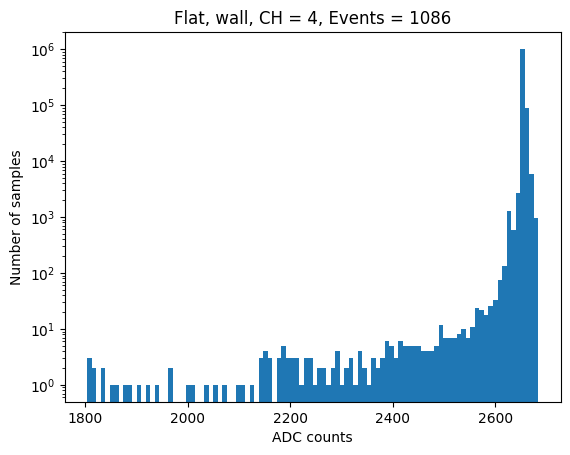

In [ ]:
channel = 4

plot_hist_counts(data_june_4_flat_arr, channel, f"Flat, wall, CH = {channel}")

In [23]:
def SPE(data_arr_arr, PMT):
  area_list = []
  for i in range(len(data_arr_arr[PMT])):
    areas = peak_area_all(data_arr_arr, PMT, i)
    if len(areas) != 0:
      for area in areas:
          if area <10000:
            area_list.append(area/13.2/5) #13.2 mV / ADC, 5 GHz --> mV * ns

  print(len(area_list))

  hist, bins = np.histogram(area_list)
  plt.hist(area_list, log=True, bins=bins)
  plt.xlim(0, 10000/13.2/5)
  plt.title(f"PMT {7} peak area histogram")
  plt.xlabel("Integrated charge [mV * ns]")
  plt.ylabel("Number of events");
  print(hist)
  print(bins)
  centers = (bins[:-1] + bins[1:]) / 2

  return hist, centers, bins, area_list

In [ ]:
file_path_7 = "/content/drive/MyDrive/Nikhef_project/DATA/July 11 window 439 cm 11.82 hours/wave_7.txt" # PMT 7
data_june_4_7 = read_data_from_file(file_path_7)

0 / 93738
18748 / 93738
37496 / 93738
56243 / 93738
74991 / 93738


123569
[16504  5806 11329 15720 19089 17689 13017  9580  7506  7329]
[  0.          15.1514678   30.3029356   45.4544034   60.60587121
  75.75733901  90.90880681 106.06027461 121.21174241 136.36321021
 151.51467802]
[16504  5806 11329 15720 19089 17689 13017  9580  7506  7329] [  7.5757339   22.7272017   37.8786695   53.03013731  68.18160511
  83.33307291  98.48454071 113.63600851 128.78747631 143.93894411] [  0.          15.1514678   30.3029356   45.4544034   60.60587121
  75.75733901  90.90880681 106.06027461 121.21174241 136.36321021
 151.51467802] [0.6156709318181826, 0.2873128333332895, 0.3345466590909093, 2.9912959848485725, 0.4407162651514641, 1.9742856363636576, 0.6619706363636486, 0.5071743484847888, 0.1600138030303621, 0.013714371212131482, 0.0925349469696495, 0.3336903333333828, 2.241395833333413, 0.33672540909090076, 0.39471065909077485, 0.4691920227272807, 0.756188530303086, 0.3422518106059959, 0.07413553030298634, 1.9845322803030079, 0.4122148181818134, 0.0320618636363412

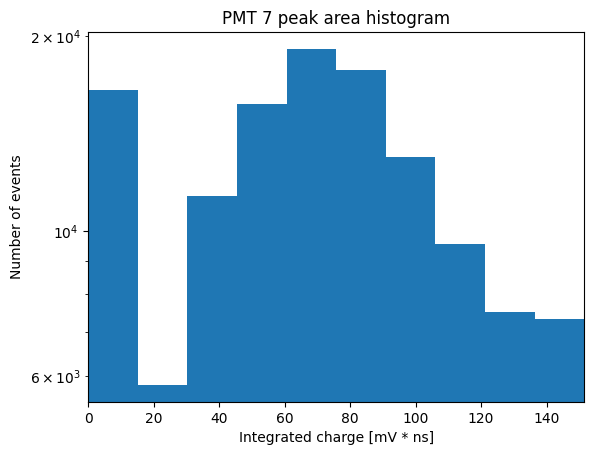

In [24]:
hist_7, centers_7, bins_7, area_list_7 = SPE(np.array([data_june_4_7]), 0)
print(hist_7, centers_7, bins_7, area_list_7)

50775
[8879 3075 3735 4609 5870 6694 6079 4493 3449 3892]
[ 0.          7.57519827 15.15039653 22.7255948  30.30079307 37.87599133
 45.4511896  53.02638787 60.60158613 68.1767844  75.75198267]
[8879 3075 3735 4609 5870 6694 6079 4493 3449 3892] [ 3.78759913 11.3627974  18.93799567 26.51319393 34.0883922  41.66359047
 49.23878873 56.813987   64.38918527 71.96438353] [ 0.          7.57519827 15.15039653 22.7255948  30.30079307 37.87599133
 45.4511896  53.02638787 60.60158613 68.1767844  75.75198267] [0.17999268181816236, 0.038677659090956586, 14.639971992424236, 0.40173525000002225, 2.4094756287878627, 0.04882075757571976, 17.32058446969689, 5.961444318181762, 0.18115047727265005, 0.10919937121214347, 0.1595957878787603, 0.4204527045453929, 0.09154360606067148, 0.4887750984847902, 0.2114887045454211, 0.7527262272727258, 4.8142533863636405, 0.7794226969696425, 0.11012218181819704, 0.12179295454553665, 0.23399029545461159, 0.0870158030302884, 0.0998682424242602, 0.15652561363634904, 1.1575

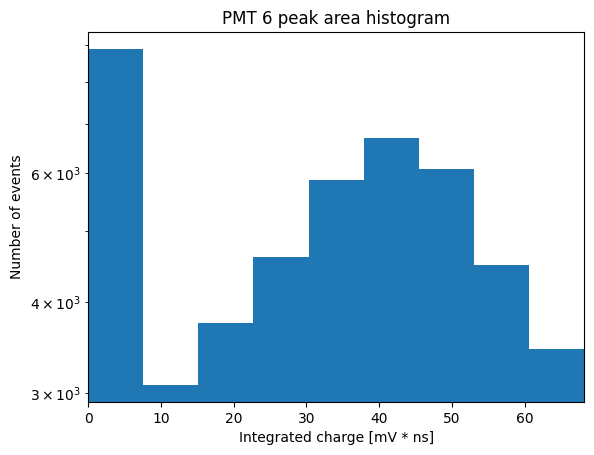

In [22]:
hist_6, centers_6, bins_6, area_list_6 = SPE(np.array([data_june_4_6]), 0)
print(hist_6, centers_6, bins_6, area_list_6)

In [ ]:
hist_6, centers_6, bins_6, area_list_6 = SPE(np.array([data_june_4_6]), 0)


In [ ]:
file_path_5 = "/content/drive/MyDrive/Nikhef_project/DATA/July 11 window 439 cm 11.82 hours/wave_5.txt" # PMT 5
data_june_4_5 = read_data_from_file(file_path_5)

13583
[7189 1994 1402  939  688  422  315  248  188  198]
[   0.          149.88853765  299.7770753   449.66561295  599.5541506
  749.44268825  899.3312259  1049.21976355 1199.1083012  1348.99683885
 1498.8853765 ]


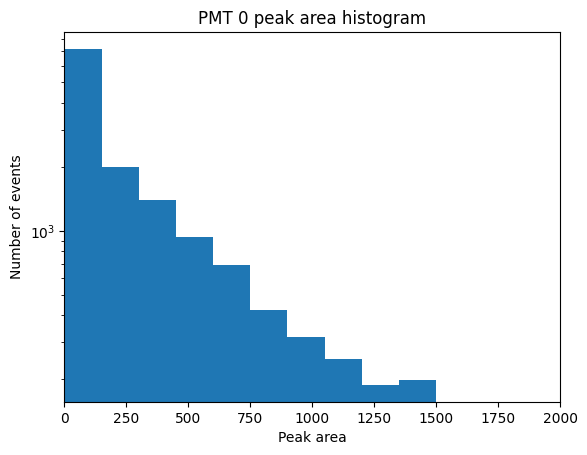

In [19]:
hist_5, centers_5, bins_5, area_list_5 = SPE(np.array([data_june_4_5]), 0)
print(hist_5, centers_5, bins_5, area_list_5)

In [42]:
file_path_4 = "/content/drive/MyDrive/Nikhef_project/DATA/July 11 window 439 cm 11.82 hours/wave_4.txt" # PMT 4
data_june_4_4 = read_data_from_file(file_path_4)

0 / 93738
18748 / 93738
37496 / 93738
56243 / 93738
74991 / 93738


36743
[4256 3299 3122 3263 3615 3737 4060 4012 3866 3513]
[   0.         149.9976069  299.9952138  449.9928207  599.9904276
  749.9880345  899.9856414 1049.9832483 1199.9808552 1349.9784621
 1499.976069 ]


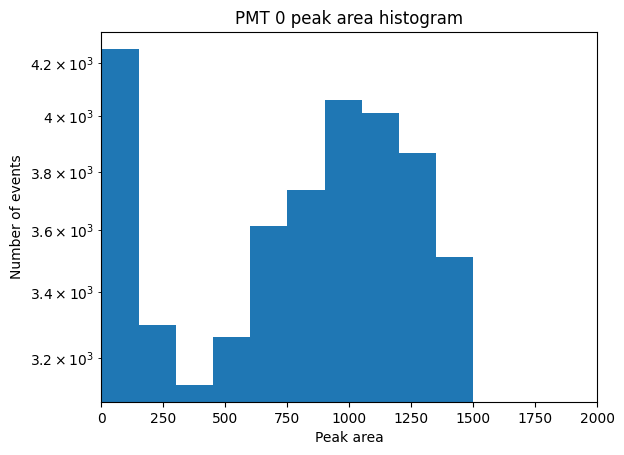

In [47]:
hist_4, centers_4, bins_4, area_list_4 = SPE(np.array([data_june_4_4]), 0)

49
[19 19  6  1  1  0  1  0  0  2]
[ 130.2426755  258.1879019  386.1331283  514.0783547  642.0235811
  769.9688075  897.9140339 1025.8592603 1153.8044867 1281.7497131
 1409.6949395]


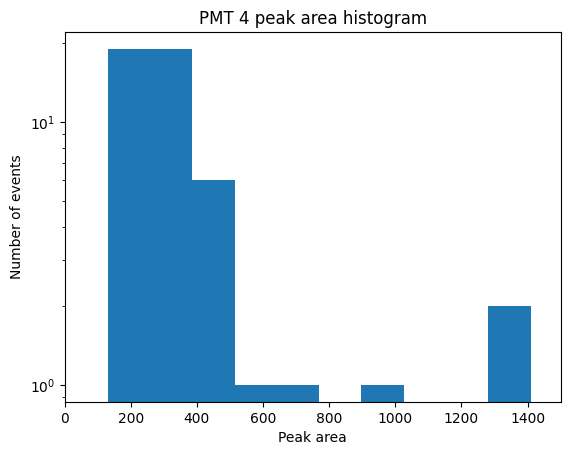

In [34]:
hist, centers, bins, area_list = SPE(data_june_4_flat_arr, 4)

In [ ]:
amp1_0 = 150000
amp2_0 = 12000
amp3_0 = 38000
mu1_0 = 300
sigma1_0 = 100
sigma2_0 = 225
sigma3_0 = 250
param_bounds = ([0,0,15000,100,50,50,50], [300000, 200000, 200000,1000, 500,500,1000])  # lower and upper bounds
p0 = [amp1_0, amp2_0, amp3_0, mu1_0, sigma1_0, sigma2_0, sigma3_0]
# params, _ = curve_fit(gaussian_triple, centers_6, hist_6, p0=p0, bounds=param_bounds)
params = p0

# Plot fitted Gaussian function
x = np.linspace(min(centers_4)-100, max(centers_4)+100, 1000)
# plt.plot(x, gaussian(x, params[0], params[3], params[4]) + gaussian(x, params[1], params[3], params[5]) + gaussian(x, params[2], params[3], params[6]), label='Total')

plt.plot(x, gaussian(x, params[0], params[3],   params[4]), label=f'$\mu_1$ = {params[3]:.2f},   $\sigma_1 = $ {params[4]:.2f}')
plt.plot(x, gaussian(x, params[1], 2*params[3], params[5]), label=f'$\mu_2$ = {2*params[3]:.2f}, $\sigma_2 = $ {params[5]:.2f}')
plt.plot(x, gaussian(x, params[2], 3*params[3], params[6]), label=f'$\mu_3$ = {3*params[3]:.2f}, $\sigma_3 = $ {params[6]:.2f}')
# plt.plot(x, gaussian(x, amp3_0, 3*329, sigma3_0))

plt.scatter(centers_4, hist_4, c='red')
plt.hist(area_list_4, log=True, bins=bins_4)

# plt.ylim(0.9, 1e3)
plt.xlim(0, 5000/13.2/5)
print(params)
print(f'1SPE: {params[3]:.2f}')
print(f'2: {2*params[3]:.2f}')
print(f'3: {3*params[3]:.2f}')

# Show the plot
plt.legend();
plt.xlabel('Integrated charge [mV * ns]')
plt.yscale('log')
plt.title('PMT 4 Calibration')
plt.ylabel('Number of events')
plt.show();

[600000, 500000, 380000, 40, 20, 15, 15]
1SPE: 40.00
2: 80.00
3: 120.00


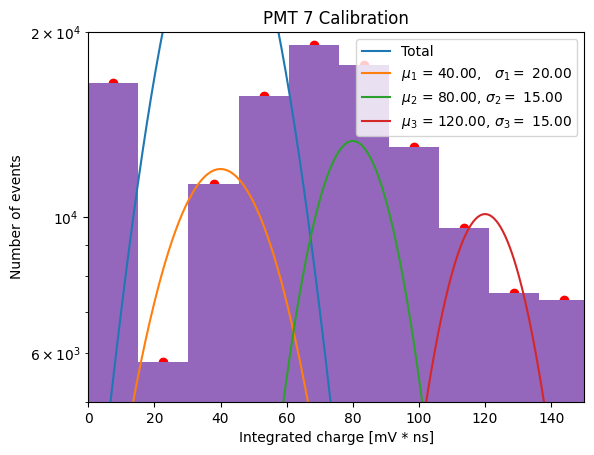

In [58]:
amp1_0 = 600000
amp2_0 = 800000
amp3_0 = 380000
mu1_0 = 40
sigma1_0 = 20
sigma2_0 = 15
sigma3_0 = 15
param_bounds = ([500000,400000,300000,20,1,1,1], [1000000, 800000, 500000,100, 50,50,100])  # lower and upper bounds
p0 = [amp1_0, amp2_0, amp3_0, mu1_0, sigma1_0, sigma2_0, sigma3_0]
# params, _ = curve_fit(gaussian_triple, centers_7, hist_7, p0=p0, bounds=param_bounds)
# params = p0

# Plot fitted Gaussian function
x = np.linspace(min(centers_7)-100, max(centers_7)+100, 1000)
plt.plot(x, gaussian(x, params[0], params[3], params[4]) + gaussian(x, params[1], params[3], params[5]) + gaussian(x, params[2], params[3], params[6]), label='Total')

plt.plot(x, gaussian(x, params[0], params[3],   params[4]), label=f'$\mu_1$ = {params[3]:.2f},   $\sigma_1 = $ {params[4]:.2f}')
plt.plot(x, gaussian(x, params[1], 2*params[3], params[5]), label=f'$\mu_2$ = {2*params[3]:.2f}, $\sigma_2 = $ {params[5]:.2f}')
plt.plot(x, gaussian(x, params[2], 3*params[3], params[6]), label=f'$\mu_3$ = {3*params[3]:.2f}, $\sigma_3 = $ {params[6]:.2f}')
# plt.plot(x, gaussian(x, amp3_0, 3*329, sigma3_0))

plt.scatter(centers_7, hist_7, c='red')
plt.hist(area_list_7, log=True, bins=bins_7)

plt.ylim(5e3, 2e4)
plt.xlim(0, 150)
print(params)
print(f'1SPE: {params[3]:.2f}')
print(f'2: {2*params[3]:.2f}')
print(f'3: {3*params[3]:.2f}')

# Show the plot
plt.legend();
plt.xlabel('Integrated charge [mV * ns]')
plt.yscale('log')
plt.title('PMT 7 Calibration')
plt.ylabel('Number of events')
plt.show();